# Multinomial logistic regression model : training and prediction
This notebook contains the implementation of a multinomial logistic regression model for the classification of the ImageNet dataset. The model is trained with custom dataset constructed with penultimate layer outputs from ResNet-50 evaluation (Cf. [Penultimate layer outputs saving](./penultimate_layer_outputs_saving.ipynb) notebook). Training is conducted for different values of weight decay in order to study its impact on the learning of the classes.

## Import
This cell imports the required modules for this notebook.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader 
from torchinfo import summary

import pandas as pd
import numpy as np

import json
import os
import string

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

from tqdm import tqdm

## Classes

#### Custom dataset

In [4]:
class PenultimateOutputsDataset(Dataset):
    def __init__(self, folder_path, device='cpu'):
        with open(f'{folder_path}/penultimate_layer_outputs/data.json') as data:
            self.data_tensors = json.load(data)
        self.file_list = [f'{folder_path}/penultimate_layer_outputs/penultimate_layer_outputs_{index}.pt' for index in range(self.data_tensors['last_file_indice']+1)]
        self.labels = torch.load(f'{folder_path}/penultimate_layer_labels.pt', map_location=device)
        self.length = self.data_tensors['min_size_segmentation']*self.data_tensors['last_file_indice']+torch.load(f'{folder_path}/penultimate_layer_outputs/penultimate_layer_outputs_{self.data_tensors["last_file_indice"]}.pt', map_location=device).shape[0]
        self.device = device
        self.data_cache = None
        
    def __len__(self):
        return self.length

    def __getitem__(self, index):
        if index < 0 or index >= self.length :
           raise ValueError(f'Index need to be between 0 and {self.length-1}')
        index_file = index//self.data_tensors['min_size_segmentation']
        index_in_file = index%self.data_tensors['min_size_segmentation']
        if (self.data_cache is None) or self.data_cache[0] != index_file :
            file = self.file_list[index_file]
            tensors = torch.load(file, map_location=self.device)
            self.data_cache = (index_file, tensors)
        tensor = self.data_cache[1][index_in_file]
        label = self.labels[index]
        return tensor, label


#### LogisticRegression model

In [7]:
torch.manual_seed(0) # Experiment reproducibility

class LogisticRegression(nn.Module): 
    def __init__(self, input_size, num_classes): 
        super(LogisticRegression, self).__init__() 
        self.linear = nn.Linear(input_size, num_classes) 
  
    def forward(self, x): 
        out = self.linear(x) 
        return out 

## Set up hyperparameters

In [5]:
# Définition des constantes et des hyper-paramètres

outputs_folder = "../data/saved_outputs/train"
common_subfolders_name = "weight_decay_"
models_folder = "../data/saved_models/various_weight_decay_models"
if not os.path.exists(models_folder):
    os.makedirs(models_folder)
    
input_size = 2048
num_classes = 1000

batch_size = 256
num_epochs = 90

num_weight_decay = 11
weight_decay_parameters = torch.cat(torch.tensor([0]), (torch.logspace(-7,-2, num_weight_decay)), dim=0)
learning_rate = 0.1
momentum = 0.9
lr_decay_step = 30
decay_rate = 0.1


## Initialization 

In [3]:
# Utilisation du GPU si disponible
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Instanciation du dataset et du dataloader
dataset = PenultimateOutputsDataset(outputs_folder)
train_loader = DataLoader(dataset, batch_size=batch_size, pin_memory=True)
len(dataset)

1281167

## Training

In [7]:
# Entraînement des modèles
for training_index, weight_decay_parameter in enumerate(weight_decay_parameters) :

    print(f"Processing step {training_index+1}/{len(weight_decay_parameters)}, weight decay = {weight_decay_parameter:.3e}.")
    
    # On définit le modèle
    model = LogisticRegression(input_size=input_size, num_classes=num_classes) 
    model = model.to(DEVICE)

    # Définition de la fonction de loss et de l'optimiseur
    loss_function = nn.CrossEntropyLoss() 
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay_parameter)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_step, gamma=decay_rate)

    # Définition du répertoire associé
    folder_path = os.path.join(models_folder, f"{training_index+1}_weight_decay_{weight_decay_parameter:.3e}")
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    # Initialisation des différentes variables pour stocker les éléments intéressants
    accuracy_history = []
    loss_history = torch.tensor([]).to(DEVICE) 
    complete_optimized_function_value_history = torch.tensor([]).to(DEVICE) 
    mean_loss_class = torch.tensor([]).to(DEVICE) 
    weights_epoch = torch.tensor([]).to(DEVICE) 

    # Obtention du nombre d'images par classe
    nb_image_class = torch.bincount(dataset.labels).to(DEVICE)
    
    for epoch in range(num_epochs): 

        # Définition des répertoires associés
        models_path = os.path.join(folder_path, "models")
        data_path = os.path.join(folder_path, "data")
        if not os.path.exists(models_path):
            os.makedirs(models_path)
        if not os.path.exists(data_path):
            os.makedirs(data_path)
            
        # Initialisation du nombre de prédictions correctes
        correct_predictions = 0
    
        # Initialisation du vecteur de la somme des erreurs pour chaque classe
        class_loss = torch.zeros(1000, device=DEVICE)
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]"):
            
            # Chargement dans le bon appareil
            inputs = inputs.to(DEVICE) 
            labels = labels.to(DEVICE)
            
            # Forward pass 
            outputs = model(inputs) 
            loss = loss_function(outputs, labels)
            complete_optimized_function_value = loss + weight_decay_parameter * sum(t.pow(2).sum() for t in model.state_dict().values()) / 2
    
            # Calcul des erreurs pour chaque image et ajout dans class_loss
            input_loss = nn.functional.cross_entropy(outputs,labels,reduction='none') + weight_decay_parameter * sum(t.pow(2).sum() for t in model.state_dict().values()) / 2
            class_loss.index_add_(0,labels,input_loss)
            
            # Ajout des prédictions correctes au total
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
    
            # Backward and optimize 
            optimizer.zero_grad() 
            loss.backward() 
            optimizer.step()
        
        # Modification du lerning rate
        scheduler.step()
    
        # Sauvegarde du modèle intermédiaire
        torch.save(model.state_dict(), f'{models_path}/epoch-{epoch}.pt')
    
        # Calcul de la précision
        accuracy = 100 * correct_predictions / len(dataset)
    
        # Sauvegarde des différentes mesures
        accuracy_history.append(accuracy)
        loss_history = torch.cat((loss_history, loss.unsqueeze(0)), dim=0)
        complete_optimized_function_value_history = torch.cat((complete_optimized_function_value_history, complete_optimized_function_value.unsqueeze(0)), dim=0)
        mean_loss_class = torch.cat((mean_loss_class, (class_loss/nb_image_class).detach().unsqueeze(0)), dim=0)
        weights_epoch = torch.cat((weights_epoch, sum(t.abs().sum() for t in model.state_dict().values()).unsqueeze(0)), dim=0)
        
        # Affichage
        print(f'>> Accuracy: {accuracy} %\n-- Loss: {loss.item()}\n-- Complete optimized function value: {complete_optimized_function_value.item()}')
            
    # Sauvegarde de toutes les données importantes liées à l'entraînement du modèle
    torch.save(accuracy_history, f'{data_path}/accuracy.pt')
    torch.save(loss_history, f'{data_path}/loss.pt')
    torch.save(complete_optimized_function_value_history, f'{data_path}/complete_optimized_function_values.pt')
    torch.save(mean_loss_class, f'{data_path}/mean_loss_class.pt')
    torch.save(weights_epoch, f'{data_path}/weights.pt')

    print(f"Step {training_index+1}/{len(weight_decay_parameters)} completed.")

Processing step 1/9, weight decay = 1.000e-06.


Epoch [1/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:33<00:00, 151.42it/s]


>> Accuracy: 8.454791607963676 %
-- Loss: 39.4916877746582
-- Complete optimized function value: 39.74224853515625


Epoch [2/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.09it/s]


>> Accuracy: 61.90114169347166 %
-- Loss: 21.195581436157227
-- Complete optimized function value: 21.489025115966797


Epoch [3/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:41<00:00, 120.86it/s]


>> Accuracy: 72.09903158604617 %
-- Loss: 14.347871780395508
-- Complete optimized function value: 14.6565523147583


Epoch [4/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:40<00:00, 122.85it/s]


>> Accuracy: 76.4551381669993 %
-- Loss: 10.762030601501465
-- Complete optimized function value: 11.075008392333984


Epoch [5/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:40<00:00, 123.20it/s]


>> Accuracy: 78.11963623789873 %
-- Loss: 9.570527076721191
-- Complete optimized function value: 9.885831832885742


Epoch [6/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:42<00:00, 119.08it/s]


>> Accuracy: 79.32650466332649 %
-- Loss: 9.280062675476074
-- Complete optimized function value: 9.595479011535645


Epoch [7/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:41<00:00, 121.12it/s]


>> Accuracy: 79.7852270625141 %
-- Loss: 8.976760864257812
-- Complete optimized function value: 9.29271411895752


Epoch [8/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:41<00:00, 120.50it/s]


>> Accuracy: 80.28680101813424 %
-- Loss: 8.742135047912598
-- Complete optimized function value: 9.058304786682129


Epoch [9/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:42<00:00, 119.16it/s]


>> Accuracy: 80.5428176030135 %
-- Loss: 8.485804557800293
-- Complete optimized function value: 8.80234432220459


Epoch [10/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 138.44it/s]


>> Accuracy: 80.91685158921514 %
-- Loss: 8.085623741149902
-- Complete optimized function value: 8.402020454406738


Epoch [11/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:32<00:00, 154.28it/s]


>> Accuracy: 80.9578298535632 %
-- Loss: 7.594228744506836
-- Complete optimized function value: 7.911795616149902


Epoch [12/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:33<00:00, 150.16it/s]


>> Accuracy: 81.32577564049028 %
-- Loss: 7.182719707489014
-- Complete optimized function value: 7.500428676605225


Epoch [13/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.41it/s]


>> Accuracy: 81.3218729486476 %
-- Loss: 6.877143383026123
-- Complete optimized function value: 7.195843696594238


Epoch [14/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 141.54it/s]


>> Accuracy: 81.56165433546134 %
-- Loss: 6.622303485870361
-- Complete optimized function value: 6.9420247077941895


Epoch [15/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:51<00:00, 96.76it/s]


>> Accuracy: 81.57406489552103 %
-- Loss: 6.368736267089844
-- Complete optimized function value: 6.68966817855835


Epoch [16/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:54<00:00, 92.15it/s]


>> Accuracy: 81.8417895559283 %
-- Loss: 6.082594394683838
-- Complete optimized function value: 6.404461860656738


Epoch [17/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:45<00:00, 109.60it/s]


>> Accuracy: 81.72751873877488 %
-- Loss: 5.800743103027344
-- Complete optimized function value: 6.124596118927002


Epoch [18/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:46<00:00, 106.91it/s]


>> Accuracy: 82.06268191422352 %
-- Loss: 5.543192386627197
-- Complete optimized function value: 5.868131637573242


Epoch [19/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [01:01<00:00, 80.73it/s]


>> Accuracy: 81.94107403640587 %
-- Loss: 5.3036346435546875
-- Complete optimized function value: 5.630520820617676


Epoch [20/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:45<00:00, 110.48it/s]


>> Accuracy: 82.17703078521379 %
-- Loss: 5.088953018188477
-- Complete optimized function value: 5.417547225952148


Epoch [21/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:45<00:00, 109.88it/s]


>> Accuracy: 82.10935810866187 %
-- Loss: 4.889261245727539
-- Complete optimized function value: 5.220004081726074


Epoch [22/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:47<00:00, 105.64it/s]


>> Accuracy: 82.2955165095573 %
-- Loss: 4.702630519866943
-- Complete optimized function value: 5.035473823547363


Epoch [23/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:49<00:00, 102.13it/s]


>> Accuracy: 82.26203141354718 %
-- Loss: 4.526398658752441
-- Complete optimized function value: 4.861507892608643


Epoch [24/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:42<00:00, 117.64it/s]


>> Accuracy: 82.51313060670466 %
-- Loss: 4.367766857147217
-- Complete optimized function value: 4.704834461212158


Epoch [25/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:48<00:00, 103.90it/s]


>> Accuracy: 82.37216537734737 %
-- Loss: 4.2212347984313965
-- Complete optimized function value: 4.561081886291504


Epoch [26/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:46<00:00, 108.42it/s]


>> Accuracy: 82.63762647648589 %
-- Loss: 4.087313652038574
-- Complete optimized function value: 4.429201602935791


Epoch [27/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:43<00:00, 115.79it/s]


>> Accuracy: 82.46723495063485 %
-- Loss: 3.941706418991089
-- Complete optimized function value: 4.286652088165283


Epoch [28/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:43<00:00, 116.33it/s]


>> Accuracy: 82.76524449974126 %
-- Loss: 3.8144779205322266
-- Complete optimized function value: 4.161630153656006


Epoch [29/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:42<00:00, 116.85it/s]


>> Accuracy: 82.60367305745464 %
-- Loss: 3.6694753170013428
-- Complete optimized function value: 4.0198187828063965


Epoch [30/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:42<00:00, 117.35it/s]


>> Accuracy: 82.91604451254209 %
-- Loss: 3.5260040760040283
-- Complete optimized function value: 3.878535270690918


Epoch [31/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:42<00:00, 116.68it/s]


>> Accuracy: 85.28583705324911 %
-- Loss: 1.745184063911438
-- Complete optimized function value: 2.095613479614258


Epoch [32/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:41<00:00, 119.59it/s]


>> Accuracy: 89.0503736046901 %
-- Loss: 1.7338340282440186
-- Complete optimized function value: 2.082685708999634


Epoch [33/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 125.80it/s]


>> Accuracy: 90.10058797955301 %
-- Loss: 1.7001169919967651
-- Complete optimized function value: 2.047584056854248


Epoch [34/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:42<00:00, 117.14it/s]


>> Accuracy: 90.57164288496348 %
-- Loss: 1.6606788635253906
-- Complete optimized function value: 2.006856918334961


Epoch [35/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:42<00:00, 117.63it/s]


>> Accuracy: 90.82836195437442 %
-- Loss: 1.6205500364303589
-- Complete optimized function value: 1.9654948711395264


Epoch [36/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:43<00:00, 115.55it/s]


>> Accuracy: 90.98298660518105 %
-- Loss: 1.5840883255004883
-- Complete optimized function value: 1.927837610244751


Epoch [37/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:43<00:00, 116.22it/s]


>> Accuracy: 91.10162843719827 %
-- Loss: 1.5515865087509155
-- Complete optimized function value: 1.8941681385040283


Epoch [38/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:42<00:00, 116.69it/s]


>> Accuracy: 91.18132140462562 %
-- Loss: 1.5222477912902832
-- Complete optimized function value: 1.8636837005615234


Epoch [39/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:43<00:00, 116.32it/s]


>> Accuracy: 91.24946240419867 %
-- Loss: 1.4965931177139282
-- Complete optimized function value: 1.8369019031524658


Epoch [40/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 132.74it/s]


>> Accuracy: 91.30511478987516 %
-- Loss: 1.4737203121185303
-- Complete optimized function value: 1.8129181861877441


Epoch [41/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:33<00:00, 149.83it/s]


>> Accuracy: 91.35545951464563 %
-- Loss: 1.4531484842300415
-- Complete optimized function value: 1.7912499904632568


Epoch [42/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:33<00:00, 150.94it/s]


>> Accuracy: 91.39596945597256 %
-- Loss: 1.4338890314102173
-- Complete optimized function value: 1.7709072828292847


Epoch [43/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 138.36it/s]


>> Accuracy: 91.43452805137815 %
-- Loss: 1.4153310060501099
-- Complete optimized function value: 1.7512784004211426


Epoch [44/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 135.24it/s]


>> Accuracy: 91.46824730889884 %
-- Loss: 1.397111177444458
-- Complete optimized function value: 1.7319992780685425


Epoch [45/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:50<00:00, 99.54it/s]


>> Accuracy: 91.4982980360874 %
-- Loss: 1.3788495063781738
-- Complete optimized function value: 1.7126891613006592


Epoch [46/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:48<00:00, 103.27it/s]


>> Accuracy: 91.527802386418 %
-- Loss: 1.3609095811843872
-- Complete optimized function value: 1.693711280822754


Epoch [47/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:48<00:00, 104.12it/s]


>> Accuracy: 91.55964835185421 %
-- Loss: 1.3435755968093872
-- Complete optimized function value: 1.6753491163253784


Epoch [48/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:49<00:00, 100.43it/s]


>> Accuracy: 91.58431336429989 %
-- Loss: 1.3265630006790161
-- Complete optimized function value: 1.657317876815796


Epoch [49/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:45<00:00, 110.08it/s]


>> Accuracy: 91.6106175073195 %
-- Loss: 1.3098005056381226
-- Complete optimized function value: 1.6395460367202759


Epoch [50/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:32<00:00, 153.09it/s]


>> Accuracy: 91.63411171221239 %
-- Loss: 1.2933309078216553
-- Complete optimized function value: 1.6220760345458984


Epoch [51/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:34<00:00, 143.79it/s]


>> Accuracy: 91.65456181746798 %
-- Loss: 1.2771403789520264
-- Complete optimized function value: 1.6048938035964966


Epoch [52/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 138.90it/s]


>> Accuracy: 91.6789926684031 %
-- Loss: 1.261218786239624
-- Complete optimized function value: 1.5879889726638794


Epoch [53/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.58it/s]


>> Accuracy: 91.70155022725375 %
-- Loss: 1.2455757856369019
-- Complete optimized function value: 1.571371078491211


Epoch [54/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:40<00:00, 124.25it/s]


>> Accuracy: 91.72410778610438 %
-- Loss: 1.2301939725875854
-- Complete optimized function value: 1.5550222396850586


Epoch [55/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:44<00:00, 113.55it/s]


>> Accuracy: 91.7438554068283 %
-- Loss: 1.215048909187317
-- Complete optimized function value: 1.5389180183410645


Epoch [56/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:44<00:00, 112.69it/s]


>> Accuracy: 91.76539826579986 %
-- Loss: 1.2000999450683594
-- Complete optimized function value: 1.523017406463623


Epoch [57/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:44<00:00, 113.29it/s]


>> Accuracy: 91.783428702113 %
-- Loss: 1.185359239578247
-- Complete optimized function value: 1.5073325634002686


Epoch [58/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:44<00:00, 113.01it/s]


>> Accuracy: 91.79997611552592 %
-- Loss: 1.1708251237869263
-- Complete optimized function value: 1.4918614625930786


Epoch [59/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:44<00:00, 112.38it/s]


>> Accuracy: 91.81457218301752 %
-- Loss: 1.1564662456512451
-- Complete optimized function value: 1.4765726327896118


Epoch [60/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:44<00:00, 113.10it/s]


>> Accuracy: 91.82948046585652 %
-- Loss: 1.1422016620635986
-- Complete optimized function value: 1.4613850116729736


Epoch [61/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:44<00:00, 112.65it/s]


>> Accuracy: 92.342060012473 %
-- Loss: 1.1215795278549194
-- Complete optimized function value: 1.44069504737854


Epoch [62/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:46<00:00, 106.86it/s]


>> Accuracy: 92.35314365730619 %
-- Loss: 1.117640733718872
-- Complete optimized function value: 1.4366888999938965


Epoch [63/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:45<00:00, 110.45it/s]


>> Accuracy: 92.35774883368055 %
-- Loss: 1.113910436630249
-- Complete optimized function value: 1.4328913688659668


Epoch [64/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:43<00:00, 115.31it/s]


>> Accuracy: 92.36602254038701 %
-- Loss: 1.1103688478469849
-- Complete optimized function value: 1.429282546043396


Epoch [65/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:42<00:00, 118.55it/s]


>> Accuracy: 92.3727351703564 %
-- Loss: 1.107007384300232
-- Complete optimized function value: 1.425853967666626


Epoch [66/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.89it/s]


>> Accuracy: 92.37890142346782 %
-- Loss: 1.1038058996200562
-- Complete optimized function value: 1.4225854873657227


Epoch [67/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.97it/s]


>> Accuracy: 92.38202357694196 %
-- Loss: 1.1007561683654785
-- Complete optimized function value: 1.419468879699707


Epoch [68/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 138.50it/s]


>> Accuracy: 92.38561405343722 %
-- Loss: 1.0978436470031738
-- Complete optimized function value: 1.416489601135254


Epoch [69/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:44<00:00, 111.79it/s]


>> Accuracy: 92.38818983005338 %
-- Loss: 1.0950592756271362
-- Complete optimized function value: 1.4136384725570679


Epoch [70/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:41<00:00, 121.23it/s]


>> Accuracy: 92.3918583603855 %
-- Loss: 1.0923911333084106
-- Complete optimized function value: 1.4109036922454834


Epoch [71/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:40<00:00, 122.93it/s]


>> Accuracy: 92.3955268907176 %
-- Loss: 1.0898315906524658
-- Complete optimized function value: 1.4082775115966797


Epoch [72/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:44<00:00, 111.61it/s]


>> Accuracy: 92.40083455162363 %
-- Loss: 1.087370753288269
-- Complete optimized function value: 1.4057501554489136


Epoch [73/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:44<00:00, 112.61it/s]


>> Accuracy: 92.4034103282398 %
-- Loss: 1.0850002765655518
-- Complete optimized function value: 1.403313159942627


Epoch [74/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:44<00:00, 113.06it/s]


>> Accuracy: 92.4035664359135 %
-- Loss: 1.0827144384384155
-- Complete optimized function value: 1.400960922241211


Epoch [75/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:44<00:00, 112.86it/s]


>> Accuracy: 92.4045811357926 %
-- Loss: 1.0805058479309082
-- Complete optimized function value: 1.3986859321594238


Epoch [76/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:44<00:00, 112.40it/s]


>> Accuracy: 92.40653248171394 %
-- Loss: 1.0783686637878418
-- Complete optimized function value: 1.3964824676513672


Epoch [77/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:44<00:00, 112.85it/s]


>> Accuracy: 92.40981074286178 %
-- Loss: 1.0762989521026611
-- Complete optimized function value: 1.3943465948104858


Epoch [78/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:43<00:00, 114.89it/s]


>> Accuracy: 92.41293289633592 %
-- Loss: 1.0742911100387573
-- Complete optimized function value: 1.3922724723815918


Epoch [79/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:40<00:00, 122.74it/s]


>> Accuracy: 92.41706974968915 %
-- Loss: 1.0723392963409424
-- Complete optimized function value: 1.3902547359466553


Epoch [80/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:44<00:00, 111.50it/s]


>> Accuracy: 92.41855277258936 %
-- Loss: 1.0704377889633179
-- Complete optimized function value: 1.38828706741333


Epoch [81/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:44<00:00, 111.87it/s]


>> Accuracy: 92.42175297990036 %
-- Loss: 1.0685838460922241
-- Complete optimized function value: 1.3863672018051147


Epoch [82/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:45<00:00, 110.01it/s]


>> Accuracy: 92.42456291802708 %
-- Loss: 1.0667760372161865
-- Complete optimized function value: 1.3844934701919556


Epoch [83/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:44<00:00, 111.50it/s]


>> Accuracy: 92.4263581562747 %
-- Loss: 1.0650100708007812
-- Complete optimized function value: 1.3826615810394287


Epoch [84/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:48<00:00, 103.26it/s]


>> Accuracy: 92.4283875560329 %
-- Loss: 1.0632822513580322
-- Complete optimized function value: 1.3808679580688477


Epoch [85/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:48<00:00, 103.89it/s]


>> Accuracy: 92.43143165567018 %
-- Loss: 1.0615907907485962
-- Complete optimized function value: 1.3791108131408691


Epoch [86/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:47<00:00, 105.63it/s]


>> Accuracy: 92.43268051705984 %
-- Loss: 1.059933066368103
-- Complete optimized function value: 1.3773874044418335


Epoch [87/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:45<00:00, 110.72it/s]


>> Accuracy: 92.43455380914432 %
-- Loss: 1.0583046674728394
-- Complete optimized function value: 1.3756933212280273


Epoch [88/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:48<00:00, 103.79it/s]


>> Accuracy: 92.43666126273936 %
-- Loss: 1.0567069053649902
-- Complete optimized function value: 1.3740299940109253


Epoch [89/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:48<00:00, 102.21it/s]


>> Accuracy: 92.43814428563958 %
-- Loss: 1.055136799812317
-- Complete optimized function value: 1.372394323348999


Epoch [90/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:49<00:00, 100.32it/s]


>> Accuracy: 92.44048590074517 %
-- Loss: 1.0535944700241089
-- Complete optimized function value: 1.3707866668701172
Step 1/9 completed.
Processing step 2/9, weight decay = 3.162e-06.


Epoch [1/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:49<00:00, 101.64it/s]


>> Accuracy: 8.464236122222943 %
-- Loss: 39.2474250793457
-- Complete optimized function value: 40.03194808959961


Epoch [2/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:49<00:00, 101.77it/s]


>> Accuracy: 61.795144583024694 %
-- Loss: 20.814559936523438
-- Complete optimized function value: 21.719085693359375


Epoch [3/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:48<00:00, 102.57it/s]


>> Accuracy: 71.9214591072046 %
-- Loss: 14.140824317932129
-- Complete optimized function value: 15.07724666595459


Epoch [4/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:46<00:00, 107.41it/s]


>> Accuracy: 76.20396092000496 %
-- Loss: 10.612375259399414
-- Complete optimized function value: 11.546409606933594


Epoch [5/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:47<00:00, 105.58it/s]


>> Accuracy: 77.80984055942746 %
-- Loss: 9.515840530395508
-- Complete optimized function value: 10.44208812713623


Epoch [6/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:48<00:00, 103.18it/s]


>> Accuracy: 78.94646053168712 %
-- Loss: 9.298840522766113
-- Complete optimized function value: 10.211470603942871


Epoch [7/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:49<00:00, 101.48it/s]


>> Accuracy: 79.3291584937795 %
-- Loss: 9.096369743347168
-- Complete optimized function value: 9.997857093811035


Epoch [8/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:48<00:00, 103.13it/s]


>> Accuracy: 79.72020821641519 %
-- Loss: 8.73731517791748
-- Complete optimized function value: 9.627632141113281


Epoch [9/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:46<00:00, 108.34it/s]


>> Accuracy: 79.87053990619489 %
-- Loss: 8.474084854125977
-- Complete optimized function value: 9.35473346710205


Epoch [10/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 135.63it/s]


>> Accuracy: 80.15793413348923 %
-- Loss: 8.128288269042969
-- Complete optimized function value: 8.998276710510254


Epoch [11/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 137.08it/s]


>> Accuracy: 80.10196953246532 %
-- Loss: 7.709620475769043
-- Complete optimized function value: 8.574178695678711


Epoch [12/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:34<00:00, 145.57it/s]


>> Accuracy: 80.4037256657407 %
-- Loss: 7.250673294067383
-- Complete optimized function value: 8.107166290283203


Epoch [13/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:33<00:00, 149.20it/s]


>> Accuracy: 80.29117203299803 %
-- Loss: 6.840701103210449
-- Complete optimized function value: 7.692607402801514


Epoch [14/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 138.03it/s]


>> Accuracy: 80.44486003776245 %
-- Loss: 6.549842357635498
-- Complete optimized function value: 7.397696495056152


Epoch [15/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.63it/s]


>> Accuracy: 80.37742152272108 %
-- Loss: 6.323253631591797
-- Complete optimized function value: 7.16837739944458


Epoch [16/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 138.13it/s]


>> Accuracy: 80.57638075286047 %
-- Loss: 6.119998455047607
-- Complete optimized function value: 6.961867332458496


Epoch [17/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 132.84it/s]


>> Accuracy: 80.39092483649672 %
-- Loss: 5.901599884033203
-- Complete optimized function value: 6.743976593017578


Epoch [18/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 126.40it/s]


>> Accuracy: 80.63890187618007 %
-- Loss: 5.6905131340026855
-- Complete optimized function value: 6.530858039855957


Epoch [19/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:40<00:00, 124.84it/s]


>> Accuracy: 80.43026397027086 %
-- Loss: 5.50185489654541
-- Complete optimized function value: 6.343342304229736


Epoch [20/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 129.62it/s]


>> Accuracy: 80.61720290953483 %
-- Loss: 5.358856201171875
-- Complete optimized function value: 6.200939655303955


Epoch [21/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 128.17it/s]


>> Accuracy: 80.50246376936028 %
-- Loss: 5.230649948120117
-- Complete optimized function value: 6.074692249298096


Epoch [22/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 128.41it/s]


>> Accuracy: 80.65583955877727 %
-- Loss: 5.11414098739624
-- Complete optimized function value: 5.959969520568848


Epoch [23/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.30it/s]


>> Accuracy: 80.59620642742125 %
-- Loss: 4.996794700622559
-- Complete optimized function value: 5.845256805419922


Epoch [24/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.77it/s]


>> Accuracy: 80.77588635985785 %
-- Loss: 4.887319564819336
-- Complete optimized function value: 5.737602710723877


Epoch [25/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:34<00:00, 147.18it/s]


>> Accuracy: 80.68425115539192 %
-- Loss: 4.778088092803955
-- Complete optimized function value: 5.631507873535156


Epoch [26/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:33<00:00, 149.27it/s]


>> Accuracy: 80.81108864027874 %
-- Loss: 4.676016330718994
-- Complete optimized function value: 5.532586574554443


Epoch [27/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.45it/s]


>> Accuracy: 80.71758014372834 %
-- Loss: 4.569083213806152
-- Complete optimized function value: 5.429067134857178


Epoch [28/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 141.56it/s]


>> Accuracy: 80.92122260407893 %
-- Loss: 4.4648118019104
-- Complete optimized function value: 5.327305793762207


Epoch [29/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.61it/s]


>> Accuracy: 80.78337952819578 %
-- Loss: 4.357473850250244
-- Complete optimized function value: 5.224880218505859


Epoch [30/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.18it/s]


>> Accuracy: 80.98624145017784 %
-- Loss: 4.260332107543945
-- Complete optimized function value: 5.130502223968506


Epoch [31/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 141.74it/s]


>> Accuracy: 83.77440255641926 %
-- Loss: 1.9292056560516357
-- Complete optimized function value: 2.790700912475586


Epoch [32/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 142.40it/s]


>> Accuracy: 88.31565283838874 %
-- Loss: 1.9363552331924438
-- Complete optimized function value: 2.791151762008667


Epoch [33/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:34<00:00, 145.22it/s]


>> Accuracy: 89.56162623608007 %
-- Loss: 1.9071069955825806
-- Complete optimized function value: 2.7559070587158203


Epoch [34/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 141.27it/s]


>> Accuracy: 90.08489915834548 %
-- Loss: 1.864640235900879
-- Complete optimized function value: 2.707794189453125


Epoch [35/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.50it/s]


>> Accuracy: 90.38267454594131 %
-- Loss: 1.8159693479537964
-- Complete optimized function value: 2.653688907623291


Epoch [36/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 141.57it/s]


>> Accuracy: 90.56680354707856 %
-- Loss: 1.7627348899841309
-- Complete optimized function value: 2.5951685905456543


Epoch [37/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.79it/s]


>> Accuracy: 90.69051887849125 %
-- Loss: 1.7081314325332642
-- Complete optimized function value: 2.5353939533233643


Epoch [38/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 141.47it/s]


>> Accuracy: 90.79105222035847 %
-- Loss: 1.6556614637374878
-- Complete optimized function value: 2.47784686088562


Epoch [39/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 142.58it/s]


>> Accuracy: 90.87417955660737 %
-- Loss: 1.6068553924560547
-- Complete optimized function value: 2.4240458011627197


Epoch [40/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:34<00:00, 145.76it/s]


>> Accuracy: 90.93724705678494 %
-- Loss: 1.5629054307937622
-- Complete optimized function value: 2.3751723766326904


Epoch [41/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 141.77it/s]


>> Accuracy: 90.99555327291446 %
-- Loss: 1.5241482257843018
-- Complete optimized function value: 2.3315579891204834


Epoch [42/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 141.31it/s]


>> Accuracy: 91.04581994384807 %
-- Loss: 1.4902386665344238
-- Complete optimized function value: 2.2928524017333984


Epoch [43/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.33it/s]


>> Accuracy: 91.0918717075916 %
-- Loss: 1.46001136302948
-- Complete optimized function value: 2.2578864097595215


Epoch [44/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 141.56it/s]


>> Accuracy: 91.13152305671314 %
-- Loss: 1.4324275255203247
-- Complete optimized function value: 2.225618839263916


Epoch [45/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:33<00:00, 148.53it/s]


>> Accuracy: 91.16781809084998 %
-- Loss: 1.4068777561187744
-- Complete optimized function value: 2.1954379081726074


Epoch [46/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:34<00:00, 144.38it/s]


>> Accuracy: 91.20184956371808 %
-- Loss: 1.3826197385787964
-- Complete optimized function value: 2.1665990352630615


Epoch [47/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 142.49it/s]


>> Accuracy: 91.23970567459199 %
-- Loss: 1.3589388132095337
-- Complete optimized function value: 2.138385772705078


Epoch [48/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 141.27it/s]


>> Accuracy: 91.27607876256569 %
-- Loss: 1.3359696865081787
-- Complete optimized function value: 2.110930919647217


Epoch [49/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 141.27it/s]


>> Accuracy: 91.30527089754888 %
-- Loss: 1.3139714002609253
-- Complete optimized function value: 2.0844924449920654


Epoch [50/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 142.27it/s]


>> Accuracy: 91.3353996785743 %
-- Loss: 1.2931272983551025
-- Complete optimized function value: 2.059251308441162


Epoch [51/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 142.20it/s]


>> Accuracy: 91.36420154437322 %
-- Loss: 1.2732127904891968
-- Complete optimized function value: 2.034982681274414


Epoch [52/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:33<00:00, 151.21it/s]


>> Accuracy: 91.39386200237752 %
-- Loss: 1.2539284229278564
-- Complete optimized function value: 2.011385440826416


Epoch [53/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:32<00:00, 152.81it/s]


>> Accuracy: 91.41985393004971 %
-- Loss: 1.2350468635559082
-- Complete optimized function value: 1.9882309436798096


Epoch [54/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 142.29it/s]


>> Accuracy: 91.44654834225359 %
-- Loss: 1.2164660692214966
-- Complete optimized function value: 1.9654158353805542


Epoch [55/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 141.31it/s]


>> Accuracy: 91.47004254714646 %
-- Loss: 1.198156476020813
-- Complete optimized function value: 1.9429106712341309


Epoch [56/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.80it/s]


>> Accuracy: 91.49103902926004 %
-- Loss: 1.180065393447876
-- Complete optimized function value: 1.9206622838974


Epoch [57/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.86it/s]


>> Accuracy: 91.51484544950034 %
-- Loss: 1.1621872186660767
-- Complete optimized function value: 1.8986635208129883


Epoch [58/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 142.04it/s]


>> Accuracy: 91.5356858239402 %
-- Loss: 1.144545316696167
-- Complete optimized function value: 1.8769367933273315


Epoch [59/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 141.61it/s]


>> Accuracy: 91.55785311360658 %
-- Loss: 1.1271576881408691
-- Complete optimized function value: 1.8554998636245728


Epoch [60/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:33<00:00, 148.54it/s]


>> Accuracy: 91.57752268049364 %
-- Loss: 1.1100398302078247
-- Complete optimized function value: 1.8343677520751953


Epoch [61/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 141.57it/s]


>> Accuracy: 92.18197159308662 %
-- Loss: 1.0840531587600708
-- Complete optimized function value: 1.808117151260376


Epoch [62/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 141.60it/s]


>> Accuracy: 92.19664571441506 %
-- Loss: 1.0785276889801025
-- Complete optimized function value: 1.8023295402526855


Epoch [63/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.73it/s]


>> Accuracy: 92.20921238214846 %
-- Loss: 1.0733660459518433
-- Complete optimized function value: 1.7969064712524414


Epoch [64/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.48it/s]


>> Accuracy: 92.2167055504864 %
-- Loss: 1.0685065984725952
-- Complete optimized function value: 1.7917859554290771


Epoch [65/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 142.35it/s]


>> Accuracy: 92.22513536486656 %
-- Loss: 1.0639175176620483
-- Complete optimized function value: 1.7869362831115723


Epoch [66/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 141.76it/s]


>> Accuracy: 92.23216021018337 %
-- Loss: 1.0595883131027222
-- Complete optimized function value: 1.7823469638824463


Epoch [67/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:34<00:00, 145.53it/s]


>> Accuracy: 92.23668733272088 %
-- Loss: 1.0554836988449097
-- Complete optimized function value: 1.7779825925827026


Epoch [68/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.48it/s]


>> Accuracy: 92.2428535858323 %
-- Loss: 1.051591157913208
-- Complete optimized function value: 1.773830771446228


Epoch [69/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.86it/s]


>> Accuracy: 92.24745876220665 %
-- Loss: 1.0478880405426025
-- Complete optimized function value: 1.7698686122894287


Epoch [70/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.75it/s]


>> Accuracy: 92.24823930057518 %
-- Loss: 1.0443600416183472
-- Complete optimized function value: 1.7660820484161377


Epoch [71/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 138.42it/s]


>> Accuracy: 92.25346890764436 %
-- Loss: 1.0409904718399048
-- Complete optimized function value: 1.7624542713165283


Epoch [72/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.05it/s]


>> Accuracy: 92.25565441507625 %
-- Loss: 1.0377720594406128
-- Complete optimized function value: 1.7589777708053589


Epoch [73/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:32<00:00, 152.74it/s]


>> Accuracy: 92.25807408401872 %
-- Loss: 1.0346843004226685
-- Complete optimized function value: 1.7556324005126953


Epoch [74/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:34<00:00, 146.36it/s]


>> Accuracy: 92.26096207598229 %
-- Loss: 1.0317225456237793
-- Complete optimized function value: 1.7524131536483765


Epoch [75/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.33it/s]


>> Accuracy: 92.26587946770405 %
-- Loss: 1.0288739204406738
-- Complete optimized function value: 1.74930739402771


Epoch [76/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.44it/s]


>> Accuracy: 92.26868940583078 %
-- Loss: 1.0261143445968628
-- Complete optimized function value: 1.746291160583496


Epoch [77/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.02it/s]


>> Accuracy: 92.2713432362838 %
-- Loss: 1.0234521627426147
-- Complete optimized function value: 1.7433724403381348


Epoch [78/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.88it/s]


>> Accuracy: 92.27563619731073 %
-- Loss: 1.020877480506897
-- Complete optimized function value: 1.7405414581298828


Epoch [79/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.56it/s]


>> Accuracy: 92.27930472764284 %
-- Loss: 1.01839017868042
-- Complete optimized function value: 1.7377982139587402


Epoch [80/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 142.25it/s]


>> Accuracy: 92.28250493495383 %
-- Loss: 1.0159764289855957
-- Complete optimized function value: 1.7351288795471191


Epoch [81/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:34<00:00, 144.21it/s]


>> Accuracy: 92.28484655005944 %
-- Loss: 1.0136319398880005
-- Complete optimized function value: 1.7325290441513062


Epoch [82/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.21it/s]


>> Accuracy: 92.28757843434931 %
-- Loss: 1.0113524198532104
-- Complete optimized function value: 1.7299946546554565


Epoch [83/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.93it/s]


>> Accuracy: 92.29171528770254 %
-- Loss: 1.0091317892074585
-- Complete optimized function value: 1.7275195121765137


Epoch [84/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 141.26it/s]


>> Accuracy: 92.29319831060276 %
-- Loss: 1.006967306137085
-- Complete optimized function value: 1.7251007556915283


Epoch [85/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.12it/s]


>> Accuracy: 92.29436911815556 %
-- Loss: 1.0048530101776123
-- Complete optimized function value: 1.7227325439453125


Epoch [86/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:33<00:00, 148.50it/s]


>> Accuracy: 92.29686684093487 %
-- Loss: 1.0027878284454346
-- Complete optimized function value: 1.7204136848449707


Epoch [87/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:32<00:00, 153.15it/s]


>> Accuracy: 92.29827180999823 %
-- Loss: 1.0007708072662354
-- Complete optimized function value: 1.7181432247161865


Epoch [88/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 142.28it/s]


>> Accuracy: 92.29975483289844 %
-- Loss: 0.9987975358963013
-- Complete optimized function value: 1.715916633605957


Epoch [89/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 141.60it/s]


>> Accuracy: 92.30108174812496 %
-- Loss: 0.9968631863594055
-- Complete optimized function value: 1.7137293815612793


Epoch [90/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 141.07it/s]


>> Accuracy: 92.30279893253572 %
-- Loss: 0.9949648976325989
-- Complete optimized function value: 1.711578369140625
Step 2/9 completed.
Processing step 3/9, weight decay = 1.000e-05.


Epoch [1/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.74it/s]


>> Accuracy: 8.515985816056768 %
-- Loss: 38.6279296875
-- Complete optimized function value: 41.03181457519531


Epoch [2/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 141.93it/s]


>> Accuracy: 61.463884099418735 %
-- Loss: 19.682300567626953
-- Complete optimized function value: 22.322065353393555


Epoch [3/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.59it/s]


>> Accuracy: 71.34721702947391 %
-- Loss: 13.426590919494629
-- Complete optimized function value: 16.02967643737793


Epoch [4/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:33<00:00, 147.64it/s]


>> Accuracy: 75.41475857557992 %
-- Loss: 10.162473678588867
-- Complete optimized function value: 12.634775161743164


Epoch [5/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.22it/s]


>> Accuracy: 76.82495724601087 %
-- Loss: 9.391125679016113
-- Complete optimized function value: 11.733365058898926


Epoch [6/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.30it/s]


>> Accuracy: 77.62961425013289 %
-- Loss: 9.376016616821289
-- Complete optimized function value: 11.590733528137207


Epoch [7/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 135.78it/s]


>> Accuracy: 77.70993164825506 %
-- Loss: 9.245546340942383
-- Complete optimized function value: 11.358386039733887


Epoch [8/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.19it/s]


>> Accuracy: 77.82560743447185 %
-- Loss: 8.934647560119629
-- Complete optimized function value: 10.954111099243164


Epoch [9/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 141.58it/s]


>> Accuracy: 77.46320346996137 %
-- Loss: 8.617987632751465
-- Complete optimized function value: 10.575496673583984


Epoch [10/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 141.01it/s]


>> Accuracy: 77.51432873310037 %
-- Loss: 8.287266731262207
-- Complete optimized function value: 10.181807518005371


Epoch [11/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:34<00:00, 146.58it/s]


>> Accuracy: 77.18572207994742 %
-- Loss: 7.984699249267578
-- Complete optimized function value: 9.838645935058594


Epoch [12/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 141.39it/s]


>> Accuracy: 77.10509246647783 %
-- Loss: 7.733473777770996
-- Complete optimized function value: 9.555222511291504


Epoch [13/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 141.00it/s]


>> Accuracy: 76.7565040310904 %
-- Loss: 7.520039081573486
-- Complete optimized function value: 9.32170581817627


Epoch [14/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 141.12it/s]


>> Accuracy: 76.78889637338457 %
-- Loss: 7.319290637969971
-- Complete optimized function value: 9.100648880004883


Epoch [15/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.32it/s]


>> Accuracy: 76.5178153979926 %
-- Loss: 7.139827251434326
-- Complete optimized function value: 8.913973808288574


Epoch [16/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 141.33it/s]


>> Accuracy: 76.77234895997165 %
-- Loss: 6.99805212020874
-- Complete optimized function value: 8.75691032409668


Epoch [17/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.98it/s]


>> Accuracy: 76.48846715533573 %
-- Loss: 6.8540873527526855
-- Complete optimized function value: 8.611335754394531


Epoch [18/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:34<00:00, 145.39it/s]


>> Accuracy: 76.62646633889258 %
-- Loss: 6.732542514801025
-- Complete optimized function value: 8.48128604888916


Epoch [19/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.95it/s]


>> Accuracy: 76.41064747999285 %
-- Loss: 6.613219261169434
-- Complete optimized function value: 8.364906311035156


Epoch [20/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 141.02it/s]


>> Accuracy: 76.57143838391092 %
-- Loss: 6.528801918029785
-- Complete optimized function value: 8.276610374450684


Epoch [21/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.97it/s]


>> Accuracy: 76.22261578701294 %
-- Loss: 6.447071075439453
-- Complete optimized function value: 8.203474044799805


Epoch [22/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 139.00it/s]


>> Accuracy: 76.4003443735282 %
-- Loss: 6.393838882446289
-- Complete optimized function value: 8.151430130004883


Epoch [23/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.77it/s]


>> Accuracy: 76.13004393650476 %
-- Loss: 6.3078436851501465
-- Complete optimized function value: 8.076496124267578


Epoch [24/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 142.54it/s]


>> Accuracy: 76.40697894966074 %
-- Loss: 6.258917331695557
-- Complete optimized function value: 8.029420852661133


Epoch [25/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:34<00:00, 143.71it/s]


>> Accuracy: 76.17609570024828 %
-- Loss: 6.227654933929443
-- Complete optimized function value: 8.008679389953613


Epoch [26/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.24it/s]


>> Accuracy: 76.43343920035406 %
-- Loss: 6.218381881713867
-- Complete optimized function value: 8.000144004821777


Epoch [27/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.35it/s]


>> Accuracy: 76.21754228761746 %
-- Loss: 6.194427490234375
-- Complete optimized function value: 7.985681533813477


Epoch [28/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.21it/s]


>> Accuracy: 76.51484935219219 %
-- Loss: 6.170108795166016
-- Complete optimized function value: 7.961020469665527


Epoch [29/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.83it/s]


>> Accuracy: 76.266247881814 %
-- Loss: 6.139587879180908
-- Complete optimized function value: 7.93949556350708


Epoch [30/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.02it/s]


>> Accuracy: 76.44303982228702 %
-- Loss: 6.14259147644043
-- Complete optimized function value: 7.944450855255127


Epoch [31/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:34<00:00, 146.61it/s]


>> Accuracy: 80.35572255607583 %
-- Loss: 2.387328863143921
-- Complete optimized function value: 4.149208068847656


Epoch [32/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.83it/s]


>> Accuracy: 86.5162777374066 %
-- Loss: 2.4182729721069336
-- Complete optimized function value: 4.1488938331604


Epoch [33/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 136.38it/s]


>> Accuracy: 88.05994846885692 %
-- Loss: 2.390439748764038
-- Complete optimized function value: 4.092855453491211


Epoch [34/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 139.01it/s]


>> Accuracy: 88.70038020023931 %
-- Loss: 2.3325676918029785
-- Complete optimized function value: 4.008387565612793


Epoch [35/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.84it/s]


>> Accuracy: 89.07839493212047 %
-- Loss: 2.261317014694214
-- Complete optimized function value: 3.9115922451019287


Epoch [36/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.66it/s]


>> Accuracy: 89.33214795573099 %
-- Loss: 2.185213327407837
-- Complete optimized function value: 3.810734510421753


Epoch [37/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:32<00:00, 152.62it/s]


>> Accuracy: 89.49332912883332 %
-- Loss: 2.110074520111084
-- Complete optimized function value: 3.711495876312256


Epoch [38/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:32<00:00, 152.08it/s]


>> Accuracy: 89.61821526779882 %
-- Loss: 2.035799264907837
-- Complete optimized function value: 3.61368989944458


Epoch [39/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.63it/s]


>> Accuracy: 89.72569540114598 %
-- Loss: 1.9632514715194702
-- Complete optimized function value: 3.518124580383301


Epoch [40/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.73it/s]


>> Accuracy: 89.81405234446407 %
-- Loss: 1.8947341442108154
-- Complete optimized function value: 3.4270639419555664


Epoch [41/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.33it/s]


>> Accuracy: 89.90256539545587 %
-- Loss: 1.8315694332122803
-- Complete optimized function value: 3.341801166534424


Epoch [42/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.74it/s]


>> Accuracy: 89.97414076385046 %
-- Loss: 1.7739126682281494
-- Complete optimized function value: 3.2624716758728027


Epoch [43/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.53it/s]


>> Accuracy: 90.05297513907243 %
-- Loss: 1.7220746278762817
-- Complete optimized function value: 3.1893675327301025


Epoch [44/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.39it/s]


>> Accuracy: 90.1252529919987 %
-- Loss: 1.6763848066329956
-- Complete optimized function value: 3.1227991580963135


Epoch [45/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:34<00:00, 146.69it/s]


>> Accuracy: 90.1777051703642 %
-- Loss: 1.6353999376296997
-- Complete optimized function value: 3.061307430267334


Epoch [46/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.48it/s]


>> Accuracy: 90.23148426395622 %
-- Loss: 1.5978175401687622
-- Complete optimized function value: 3.0035791397094727


Epoch [47/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.50it/s]


>> Accuracy: 90.27894099676311 %
-- Loss: 1.5629273653030396
-- Complete optimized function value: 2.9488911628723145


Epoch [48/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.67it/s]


>> Accuracy: 90.32749048328594 %
-- Loss: 1.5300488471984863
-- Complete optimized function value: 2.8965537548065186


Epoch [49/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.58it/s]


>> Accuracy: 90.37502526992968 %
-- Loss: 1.498609185218811
-- Complete optimized function value: 2.8459858894348145


Epoch [50/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.65it/s]


>> Accuracy: 90.41576937276717 %
-- Loss: 1.4686543941497803
-- Complete optimized function value: 2.7972230911254883


Epoch [51/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 141.73it/s]


>> Accuracy: 90.45128386853548 %
-- Loss: 1.4397635459899902
-- Complete optimized function value: 2.749833106994629


Epoch [52/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:34<00:00, 143.89it/s]


>> Accuracy: 90.48554950291414 %
-- Loss: 1.4117521047592163
-- Complete optimized function value: 2.703625202178955


Epoch [53/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.65it/s]


>> Accuracy: 90.52207869856154 %
-- Loss: 1.384358286857605
-- Complete optimized function value: 2.6583309173583984


Epoch [54/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.32it/s]


>> Accuracy: 90.55072445668675 %
-- Loss: 1.357494592666626
-- Complete optimized function value: 2.613856315612793


Epoch [55/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.29it/s]


>> Accuracy: 90.57905799946455 %
-- Loss: 1.3311671018600464
-- Complete optimized function value: 2.570199489593506


Epoch [56/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.74it/s]


>> Accuracy: 90.60895261897942 %
-- Loss: 1.3054499626159668
-- Complete optimized function value: 2.5274291038513184


Epoch [57/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.54it/s]


>> Accuracy: 90.63806670012575 %
-- Loss: 1.2802373170852661
-- Complete optimized function value: 2.485433578491211


Epoch [58/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 141.73it/s]


>> Accuracy: 90.67092736544105 %
-- Loss: 1.255466341972351
-- Complete optimized function value: 2.444149971008301


Epoch [59/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.12it/s]


>> Accuracy: 90.69855842368716 %
-- Loss: 1.2312177419662476
-- Complete optimized function value: 2.4036498069763184


Epoch [60/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.12it/s]


>> Accuracy: 90.72759445099663 %
-- Loss: 1.2072726488113403
-- Complete optimized function value: 2.363706350326538


Epoch [61/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.64it/s]


>> Accuracy: 91.60008023934428 %
-- Loss: 1.1635011434555054
-- Complete optimized function value: 2.3183531761169434


Epoch [62/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.06it/s]


>> Accuracy: 91.62615022085333 %
-- Loss: 1.153815746307373
-- Complete optimized function value: 2.3070945739746094


Epoch [63/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.13it/s]


>> Accuracy: 91.65596678653134 %
-- Loss: 1.1449161767959595
-- Complete optimized function value: 2.296626091003418


Epoch [64/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 141.20it/s]


>> Accuracy: 91.67829018387143 %
-- Loss: 1.1367040872573853
-- Complete optimized function value: 2.286848306655884


Epoch [65/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:34<00:00, 146.90it/s]


>> Accuracy: 91.69132517462594 %
-- Loss: 1.1291013956069946
-- Complete optimized function value: 2.2776834964752197


Epoch [66/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.36it/s]


>> Accuracy: 91.7106825261656 %
-- Loss: 1.1220322847366333
-- Complete optimized function value: 2.2690553665161133


Epoch [67/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.51it/s]


>> Accuracy: 91.72707383190482 %
-- Loss: 1.1154356002807617
-- Complete optimized function value: 2.2609028816223145


Epoch [68/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.74it/s]


>> Accuracy: 91.73753304604318 %
-- Loss: 1.1092631816864014
-- Complete optimized function value: 2.2531771659851074


Epoch [69/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.97it/s]


>> Accuracy: 91.74346513764404 %
-- Loss: 1.1034642457962036
-- Complete optimized function value: 2.2458279132843018


Epoch [70/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.55it/s]


>> Accuracy: 91.75119246749253 %
-- Loss: 1.0980095863342285
-- Complete optimized function value: 2.238825798034668


Epoch [71/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.12it/s]


>> Accuracy: 91.75899785117787 %
-- Loss: 1.0928584337234497
-- Complete optimized function value: 2.2321300506591797


Epoch [72/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:34<00:00, 146.32it/s]


>> Accuracy: 91.7641494044102 %
-- Loss: 1.087979793548584
-- Complete optimized function value: 2.2257094383239746


Epoch [73/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 136.62it/s]


>> Accuracy: 91.76898874229511 %
-- Loss: 1.083346962928772
-- Complete optimized function value: 2.2195377349853516


Epoch [74/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 137.46it/s]


>> Accuracy: 91.77250116495351 %
-- Loss: 1.0789356231689453
-- Complete optimized function value: 2.213589668273926


Epoch [75/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 136.44it/s]


>> Accuracy: 91.7755452645908 %
-- Loss: 1.0747263431549072
-- Complete optimized function value: 2.2078466415405273


Epoch [76/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 137.51it/s]


>> Accuracy: 91.77718439516472 %
-- Loss: 1.0706990957260132
-- Complete optimized function value: 2.2022881507873535


Epoch [77/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 137.67it/s]


>> Accuracy: 91.78116514084425 %
-- Loss: 1.0668381452560425
-- Complete optimized function value: 2.1968984603881836


Epoch [78/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 142.36it/s]


>> Accuracy: 91.78483367117636 %
-- Loss: 1.0631260871887207
-- Complete optimized function value: 2.1916606426239014


Epoch [79/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.60it/s]


>> Accuracy: 91.7904535474298 %
-- Loss: 1.0595486164093018
-- Complete optimized function value: 2.1865596771240234


Epoch [80/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.79it/s]


>> Accuracy: 91.79310737788282 %
-- Loss: 1.056097149848938
-- Complete optimized function value: 2.1815872192382812


Epoch [81/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.03it/s]


>> Accuracy: 91.79622953135696 %
-- Loss: 1.0527610778808594
-- Complete optimized function value: 2.1767327785491943


Epoch [82/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.26it/s]


>> Accuracy: 91.79942973866795 %
-- Loss: 1.04952871799469
-- Complete optimized function value: 2.1719841957092285


Epoch [83/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 135.25it/s]


>> Accuracy: 91.80473739957398 %
-- Loss: 1.0463883876800537
-- Complete optimized function value: 2.167330026626587


Epoch [84/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:33<00:00, 149.44it/s]


>> Accuracy: 91.80879619909037 %
-- Loss: 1.0433340072631836
-- Complete optimized function value: 2.162764310836792


Epoch [85/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:33<00:00, 150.38it/s]


>> Accuracy: 91.80903036060091 %
-- Loss: 1.0403558015823364
-- Complete optimized function value: 2.1582770347595215


Epoch [86/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.04it/s]


>> Accuracy: 91.81254278325933 %
-- Loss: 1.0374470949172974
-- Complete optimized function value: 2.1538615226745605


Epoch [87/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.22it/s]


>> Accuracy: 91.81621131359144 %
-- Loss: 1.034604787826538
-- Complete optimized function value: 2.149514675140381


Epoch [88/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 141.86it/s]


>> Accuracy: 91.81831876718648 %
-- Loss: 1.0318241119384766
-- Complete optimized function value: 2.1452317237854004


Epoch [89/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 141.32it/s]


>> Accuracy: 91.82089454380264 %
-- Loss: 1.0290988683700562
-- Complete optimized function value: 2.1410069465637207


Epoch [90/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 142.25it/s]


>> Accuracy: 91.82370448192937 %
-- Loss: 1.0264217853546143
-- Complete optimized function value: 2.1368324756622314
Step 3/9 completed.
Processing step 4/9, weight decay = 3.162e-05.


Epoch [1/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.64it/s]


>> Accuracy: 8.645321023722902 %
-- Loss: 36.32307052612305
-- Complete optimized function value: 43.22431182861328


Epoch [2/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:33<00:00, 147.31it/s]


>> Accuracy: 60.36871071452824 %
-- Loss: 16.820035934448242
-- Complete optimized function value: 23.375904083251953


Epoch [3/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.16it/s]


>> Accuracy: 69.3950905697696 %
-- Loss: 11.470683097839355
-- Complete optimized function value: 17.135648727416992


Epoch [4/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.92it/s]


>> Accuracy: 72.56267137695554 %
-- Loss: 9.224225997924805
-- Complete optimized function value: 14.015045166015625


Epoch [5/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.34it/s]


>> Accuracy: 72.97549812007334 %
-- Loss: 8.448929786682129
-- Complete optimized function value: 12.630712509155273


Epoch [6/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.65it/s]


>> Accuracy: 72.48828607043423 %
-- Loss: 8.018098831176758
-- Complete optimized function value: 11.794944763183594


Epoch [7/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.16it/s]


>> Accuracy: 71.0591203176479 %
-- Loss: 8.079493522644043
-- Complete optimized function value: 11.678563117980957


Epoch [8/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.85it/s]


>> Accuracy: 70.12309870610154 %
-- Loss: 7.718095302581787
-- Complete optimized function value: 11.229890823364258


Epoch [9/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:34<00:00, 145.21it/s]


>> Accuracy: 69.01949550683088 %
-- Loss: 7.774407386779785
-- Complete optimized function value: 11.298511505126953


Epoch [10/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 137.56it/s]


>> Accuracy: 69.17552512670089 %
-- Loss: 7.617346286773682
-- Complete optimized function value: 11.122154235839844


Epoch [11/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.35it/s]


>> Accuracy: 69.24187088802631 %
-- Loss: 7.737529277801514
-- Complete optimized function value: 11.246771812438965


Epoch [12/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 136.84it/s]


>> Accuracy: 69.33475495388188 %
-- Loss: 7.641648292541504
-- Complete optimized function value: 11.129140853881836


Epoch [13/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 138.75it/s]


>> Accuracy: 68.86846133251949 %
-- Loss: 7.864055633544922
-- Complete optimized function value: 11.368904113769531


Epoch [14/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.15it/s]


>> Accuracy: 69.00614830072894 %
-- Loss: 7.713681221008301
-- Complete optimized function value: 11.218764305114746


Epoch [15/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 142.36it/s]


>> Accuracy: 68.85113338073803 %
-- Loss: 7.641901016235352
-- Complete optimized function value: 11.177850723266602


Epoch [16/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 142.19it/s]


>> Accuracy: 69.0415847426604 %
-- Loss: 7.514760494232178
-- Complete optimized function value: 11.052446365356445


Epoch [17/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.62it/s]


>> Accuracy: 68.87267623970958 %
-- Loss: 7.491588115692139
-- Complete optimized function value: 11.041118621826172


Epoch [18/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.20it/s]


>> Accuracy: 69.07272822356492 %
-- Loss: 7.386676788330078
-- Complete optimized function value: 10.929466247558594


Epoch [19/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.64it/s]


>> Accuracy: 68.88258907698996 %
-- Loss: 7.42946720123291
-- Complete optimized function value: 10.99332332611084


Epoch [20/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 141.26it/s]


>> Accuracy: 69.27379490729936 %
-- Loss: 7.47490119934082
-- Complete optimized function value: 11.016948699951172


Epoch [21/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.06it/s]


>> Accuracy: 68.86213897173437 %
-- Loss: 7.638151168823242
-- Complete optimized function value: 11.200332641601562


Epoch [22/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:34<00:00, 146.36it/s]


>> Accuracy: 68.79563710273524 %
-- Loss: 7.569766998291016
-- Complete optimized function value: 11.140621185302734


Epoch [23/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 142.13it/s]


>> Accuracy: 68.74326297820659 %
-- Loss: 7.476420879364014
-- Complete optimized function value: 11.062566757202148


Epoch [24/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.65it/s]


>> Accuracy: 69.30517254971444 %
-- Loss: 7.440333366394043
-- Complete optimized function value: 10.99624252319336


Epoch [25/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.71it/s]


>> Accuracy: 69.18801374059744 %
-- Loss: 7.373476982116699
-- Complete optimized function value: 10.922174453735352


Epoch [26/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.26it/s]


>> Accuracy: 69.20495142319463 %
-- Loss: 7.335398197174072
-- Complete optimized function value: 10.875489234924316


Epoch [27/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.34it/s]


>> Accuracy: 68.82615615294493 %
-- Loss: 7.355216026306152
-- Complete optimized function value: 10.923728942871094


Epoch [28/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 138.34it/s]


>> Accuracy: 68.8331029444249 %
-- Loss: 7.391863822937012
-- Complete optimized function value: 10.972833633422852


Epoch [29/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 141.34it/s]


>> Accuracy: 68.66294558008441 %
-- Loss: 7.504148006439209
-- Complete optimized function value: 11.106891632080078


Epoch [30/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 137.25it/s]


>> Accuracy: 69.13602988525305 %
-- Loss: 7.533761501312256
-- Complete optimized function value: 11.109821319580078


Epoch [31/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.16it/s]


>> Accuracy: 75.85779215356 %
-- Loss: 2.2920262813568115
-- Complete optimized function value: 5.671224594116211


Epoch [32/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.87it/s]


>> Accuracy: 83.83895307949705 %
-- Loss: 2.4104647636413574
-- Complete optimized function value: 5.635051727294922


Epoch [33/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.16it/s]


>> Accuracy: 85.71271348700053 %
-- Loss: 2.356377124786377
-- Complete optimized function value: 5.4428558349609375


Epoch [34/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.23it/s]


>> Accuracy: 86.51838519100164 %
-- Loss: 2.2754969596862793
-- Complete optimized function value: 5.234012603759766


Epoch [35/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 142.22it/s]


>> Accuracy: 87.06608896420217 %
-- Loss: 2.1915886402130127
-- Complete optimized function value: 5.029645919799805


Epoch [36/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:34<00:00, 144.34it/s]


>> Accuracy: 87.36003971379219 %
-- Loss: 2.105961561203003
-- Complete optimized function value: 4.829744815826416


Epoch [37/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.64it/s]


>> Accuracy: 87.649307233171 %
-- Loss: 2.0199108123779297
-- Complete optimized function value: 4.634849548339844


Epoch [38/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.75it/s]


>> Accuracy: 87.78863333195439 %
-- Loss: 1.9355063438415527
-- Complete optimized function value: 4.446552276611328


Epoch [39/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 138.87it/s]


>> Accuracy: 87.96253728046382 %
-- Loss: 1.85751211643219
-- Complete optimized function value: 4.2692365646362305


Epoch [40/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.19it/s]


>> Accuracy: 88.04121554801209 %
-- Loss: 1.7897415161132812
-- Complete optimized function value: 4.106433391571045


Epoch [41/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.59it/s]


>> Accuracy: 88.2019283980933 %
-- Loss: 1.7303012609481812
-- Complete optimized function value: 3.955991744995117


Epoch [42/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:34<00:00, 143.78it/s]


>> Accuracy: 88.24095531652002 %
-- Loss: 1.6750231981277466
-- Complete optimized function value: 3.81353759765625


Epoch [43/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 137.07it/s]


>> Accuracy: 88.37700315415555 %
-- Loss: 1.6216137409210205
-- Complete optimized function value: 3.6765708923339844


Epoch [44/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 137.71it/s]


>> Accuracy: 88.38090584599821 %
-- Loss: 1.5703341960906982
-- Complete optimized function value: 3.5451955795288086


Epoch [45/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 138.58it/s]


>> Accuracy: 88.50922635378527 %
-- Loss: 1.5211069583892822
-- Complete optimized function value: 3.4191527366638184


Epoch [46/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 138.92it/s]


>> Accuracy: 88.49494250164108 %
-- Loss: 1.4739750623703003
-- Complete optimized function value: 3.298351287841797


Epoch [47/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.11it/s]


>> Accuracy: 88.60484230393071 %
-- Loss: 1.428276777267456
-- Complete optimized function value: 3.1819777488708496


Epoch [48/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.53it/s]


>> Accuracy: 88.58649965227016 %
-- Loss: 1.3833891153335571
-- Complete optimized function value: 3.069289445877075


Epoch [49/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:34<00:00, 143.14it/s]


>> Accuracy: 88.69007709377466 %
-- Loss: 1.3394464254379272
-- Complete optimized function value: 2.960282325744629


Epoch [50/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.39it/s]


>> Accuracy: 88.6521429290639 %
-- Loss: 1.2970142364501953
-- Complete optimized function value: 2.8554234504699707


Epoch [51/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 138.29it/s]


>> Accuracy: 88.75657896277379 %
-- Loss: 1.2561653852462769
-- Complete optimized function value: 2.7546534538269043


Epoch [52/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.52it/s]


>> Accuracy: 88.71645929063112 %
-- Loss: 1.2167577743530273
-- Complete optimized function value: 2.6577491760253906


Epoch [53/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.18it/s]


>> Accuracy: 88.80786033358649 %
-- Loss: 1.1787259578704834
-- Complete optimized function value: 2.564525604248047


Epoch [54/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.75it/s]


>> Accuracy: 88.7558764782421 %
-- Loss: 1.1420222520828247
-- Complete optimized function value: 2.474860668182373


Epoch [55/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.55it/s]


>> Accuracy: 88.83900381449101 %
-- Loss: 1.1066523790359497
-- Complete optimized function value: 2.3886566162109375


Epoch [56/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:34<00:00, 144.88it/s]


>> Accuracy: 88.77960484464555 %
-- Loss: 1.0726038217544556
-- Complete optimized function value: 2.305833578109741


Epoch [57/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 138.38it/s]


>> Accuracy: 88.86109305032053 %
-- Loss: 1.0398317575454712
-- Complete optimized function value: 2.2262473106384277


Epoch [58/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.46it/s]


>> Accuracy: 88.79178124319468 %
-- Loss: 1.0082720518112183
-- Complete optimized function value: 2.1497788429260254


Epoch [59/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.04it/s]


>> Accuracy: 88.86530795751061 %
-- Loss: 0.9778510928153992
-- Complete optimized function value: 2.076261281967163


Epoch [60/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.76it/s]


>> Accuracy: 88.79435701981085 %
-- Loss: 0.9485352039337158
-- Complete optimized function value: 2.005608558654785


Epoch [61/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.44it/s]


>> Accuracy: 90.5188004374137 %
-- Loss: 0.8599655032157898
-- Complete optimized function value: 1.9127616882324219


Epoch [62/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:34<00:00, 143.51it/s]


>> Accuracy: 90.72564310507529 %
-- Loss: 0.8404375314712524
-- Complete optimized function value: 1.889020323753357


Epoch [63/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.59it/s]


>> Accuracy: 90.85380750518863 %
-- Loss: 0.8242536783218384
-- Complete optimized function value: 1.8686628341674805


Epoch [64/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.41it/s]


>> Accuracy: 90.93607624923214 %
-- Loss: 0.810716986656189
-- Complete optimized function value: 1.850983738899231


Epoch [65/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.53it/s]


>> Accuracy: 90.98837231992394 %
-- Loss: 0.7992703914642334
-- Complete optimized function value: 1.835420846939087


Epoch [66/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.28it/s]


>> Accuracy: 91.0295066919457 %
-- Loss: 0.7894809246063232
-- Complete optimized function value: 1.8215374946594238


Epoch [67/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.93it/s]


>> Accuracy: 91.05877688076573 %
-- Loss: 0.781018853187561
-- Complete optimized function value: 1.8090028762817383


Epoch [68/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.32it/s]


>> Accuracy: 91.08289551635345 %
-- Loss: 0.7736025452613831
-- Complete optimized function value: 1.7975337505340576


Epoch [69/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 141.85it/s]


>> Accuracy: 91.10037957580862 %
-- Loss: 0.7670577168464661
-- Complete optimized function value: 1.7869553565979004


Epoch [70/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 137.71it/s]


>> Accuracy: 91.11786363526379 %
-- Loss: 0.7612137794494629
-- Complete optimized function value: 1.777096152305603


Epoch [71/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.36it/s]


>> Accuracy: 91.12957171079181 %
-- Loss: 0.7559403777122498
-- Complete optimized function value: 1.7678248882293701


Epoch [72/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.48it/s]


>> Accuracy: 91.13901622505107 %
-- Loss: 0.7511292695999146
-- Complete optimized function value: 1.7590328454971313


Epoch [73/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 138.78it/s]


>> Accuracy: 91.14939738535257 %
-- Loss: 0.7467015385627747
-- Complete optimized function value: 1.750640630722046


Epoch [74/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.58it/s]


>> Accuracy: 91.15868579193813 %
-- Loss: 0.7425915598869324
-- Complete optimized function value: 1.7425835132598877


Epoch [75/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.57it/s]


>> Accuracy: 91.16446177586529 %
-- Loss: 0.7387381196022034
-- Complete optimized function value: 1.7348004579544067


Epoch [76/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:34<00:00, 143.66it/s]


>> Accuracy: 91.17312575175602 %
-- Loss: 0.7351034283638
-- Complete optimized function value: 1.7272522449493408


Epoch [77/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 138.12it/s]


>> Accuracy: 91.17991643556226 %
-- Loss: 0.7316496968269348
-- Complete optimized function value: 1.7199008464813232


Epoch [78/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.16it/s]


>> Accuracy: 91.18553631181571 %
-- Loss: 0.7283316254615784
-- Complete optimized function value: 1.7127010822296143


Epoch [79/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.35it/s]


>> Accuracy: 91.19263921096938 %
-- Loss: 0.7251365184783936
-- Complete optimized function value: 1.7056406736373901


Epoch [80/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.60it/s]


>> Accuracy: 91.197634656528 %
-- Loss: 0.7219051718711853
-- Complete optimized function value: 1.6985609531402588


Epoch [81/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.11it/s]


>> Accuracy: 91.20372285580257 %
-- Loss: 0.7187665104866028
-- Complete optimized function value: 1.6915898323059082


Epoch [82/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 141.88it/s]


>> Accuracy: 91.20864024752433 %
-- Loss: 0.7157090306282043
-- Complete optimized function value: 1.684715986251831


Epoch [83/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 142.33it/s]


>> Accuracy: 91.21285515471442 %
-- Loss: 0.7127440571784973
-- Complete optimized function value: 1.6779506206512451


Epoch [84/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.50it/s]


>> Accuracy: 91.21667979272023 %
-- Loss: 0.7098461389541626
-- Complete optimized function value: 1.6712677478790283


Epoch [85/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.81it/s]


>> Accuracy: 91.22128496909458 %
-- Loss: 0.7070085406303406
-- Complete optimized function value: 1.6646612882614136


Epoch [86/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 137.97it/s]


>> Accuracy: 91.22534376861095 %
-- Loss: 0.7042217254638672
-- Complete optimized function value: 1.6581213474273682


Epoch [87/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.50it/s]


>> Accuracy: 91.23213445241721 %
-- Loss: 0.7014830708503723
-- Complete optimized function value: 1.6516451835632324


Epoch [88/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.99it/s]


>> Accuracy: 91.23673962879157 %
-- Loss: 0.6987790465354919
-- Complete optimized function value: 1.6452187299728394


Epoch [89/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:34<00:00, 144.77it/s]


>> Accuracy: 91.24009594377625 %
-- Loss: 0.6961097717285156
-- Complete optimized function value: 1.6388421058654785


Epoch [90/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 138.33it/s]


>> Accuracy: 91.24532555084544 %
-- Loss: 0.6934758424758911
-- Complete optimized function value: 1.6325165033340454
Step 4/9 completed.
Processing step 5/9, weight decay = 1.000e-04.


Epoch [1/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.22it/s]


>> Accuracy: 9.090696216808581 %
-- Loss: 30.316120147705078
-- Complete optimized function value: 46.752471923828125


Epoch [2/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.44it/s]


>> Accuracy: 55.732156697760715 %
-- Loss: 10.067773818969727
-- Complete optimized function value: 21.264324188232422


Epoch [3/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 137.15it/s]


>> Accuracy: 60.99353167853996 %
-- Loss: 7.378097057342529
-- Complete optimized function value: 15.795415878295898


Epoch [4/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 136.37it/s]


>> Accuracy: 58.759708921631606 %
-- Loss: 6.884037494659424
-- Complete optimized function value: 14.690762519836426


Epoch [5/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 138.40it/s]


>> Accuracy: 55.52336268417778 %
-- Loss: 6.786367416381836
-- Complete optimized function value: 14.889758110046387


Epoch [6/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 142.62it/s]


>> Accuracy: 55.03857030348112 %
-- Loss: 6.73188591003418
-- Complete optimized function value: 14.94478702545166


Epoch [7/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 138.26it/s]


>> Accuracy: 55.40378420611833 %
-- Loss: 6.704213619232178
-- Complete optimized function value: 14.890487670898438


Epoch [8/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.57it/s]


>> Accuracy: 56.32560001935735 %
-- Loss: 6.7596540451049805
-- Complete optimized function value: 14.79127311706543


Epoch [9/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 135.16it/s]


>> Accuracy: 55.58190306181786 %
-- Loss: 6.800243854522705
-- Complete optimized function value: 14.942554473876953


Epoch [10/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.80it/s]


>> Accuracy: 55.8002196434969 %
-- Loss: 6.777696132659912
-- Complete optimized function value: 14.909242630004883


Epoch [11/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.54it/s]


>> Accuracy: 55.262272599903056 %
-- Loss: 6.807068824768066
-- Complete optimized function value: 15.055072784423828


Epoch [12/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 138.53it/s]


>> Accuracy: 55.47746702810797 %
-- Loss: 6.698460102081299
-- Complete optimized function value: 14.910749435424805


Epoch [13/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 137.47it/s]


>> Accuracy: 55.700076570813955 %
-- Loss: 6.700534343719482
-- Complete optimized function value: 14.858640670776367


Epoch [14/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 135.33it/s]


>> Accuracy: 55.98801717496626 %
-- Loss: 6.753918170928955
-- Complete optimized function value: 14.84559440612793


Epoch [15/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 137.19it/s]


>> Accuracy: 55.685168287974946 %
-- Loss: 6.697136878967285
-- Complete optimized function value: 14.825100898742676


Epoch [16/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 138.63it/s]


>> Accuracy: 55.58088836193876 %
-- Loss: 6.718567371368408
-- Complete optimized function value: 14.867164611816406


Epoch [17/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 138.67it/s]


>> Accuracy: 55.68680741854887 %
-- Loss: 6.723609447479248
-- Complete optimized function value: 14.871988296508789


Epoch [18/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.43it/s]


>> Accuracy: 55.50736164762283 %
-- Loss: 6.763362884521484
-- Complete optimized function value: 14.937167167663574


Epoch [19/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:34<00:00, 144.05it/s]


>> Accuracy: 55.73668382029821 %
-- Loss: 6.713622570037842
-- Complete optimized function value: 14.847394943237305


Epoch [20/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 138.44it/s]


>> Accuracy: 55.640521493294784 %
-- Loss: 6.747063159942627
-- Complete optimized function value: 14.9073486328125


Epoch [21/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 138.68it/s]


>> Accuracy: 55.263833676640125 %
-- Loss: 6.890750885009766
-- Complete optimized function value: 15.183436393737793


Epoch [22/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 137.59it/s]


>> Accuracy: 55.85961861334237 %
-- Loss: 6.64307165145874
-- Complete optimized function value: 14.78173828125


Epoch [23/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 138.99it/s]


>> Accuracy: 55.832924201138496 %
-- Loss: 6.737165927886963
-- Complete optimized function value: 14.84251594543457


Epoch [24/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 138.94it/s]


>> Accuracy: 55.62381797220815 %
-- Loss: 6.679389953613281
-- Complete optimized function value: 14.811836242675781


Epoch [25/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 135.67it/s]


>> Accuracy: 55.64013122411052 %
-- Loss: 6.701090335845947
-- Complete optimized function value: 14.831199645996094


Epoch [26/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 136.67it/s]


>> Accuracy: 55.76119272507019 %
-- Loss: 6.782956123352051
-- Complete optimized function value: 14.921244621276855


Epoch [27/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.55it/s]


>> Accuracy: 55.535929351911186 %
-- Loss: 6.762697219848633
-- Complete optimized function value: 14.919730186462402


Epoch [28/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.04it/s]


>> Accuracy: 55.65597615299176 %
-- Loss: 6.758286476135254
-- Complete optimized function value: 14.928092002868652


Epoch [29/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.16it/s]


>> Accuracy: 55.755182579632475 %
-- Loss: 6.649852752685547
-- Complete optimized function value: 14.778903007507324


Epoch [30/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 138.91it/s]


>> Accuracy: 55.641380085500174 %
-- Loss: 6.729222297668457
-- Complete optimized function value: 14.881257057189941


Epoch [31/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:34<00:00, 145.45it/s]


>> Accuracy: 69.05727356386794 %
-- Loss: 1.643328070640564
-- Complete optimized function value: 8.713598251342773


Epoch [32/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:33<00:00, 151.53it/s]


>> Accuracy: 80.71266275200657 %
-- Loss: 1.9238311052322388
-- Complete optimized function value: 8.168075561523438


Epoch [33/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.97it/s]


>> Accuracy: 83.18696938026034 %
-- Loss: 1.8489360809326172
-- Complete optimized function value: 7.3930344581604


Epoch [34/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 125.94it/s]


>> Accuracy: 84.39875519740986 %
-- Loss: 1.7084543704986572
-- Complete optimized function value: 6.642088890075684


Epoch [35/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.38it/s]


>> Accuracy: 84.98907636553236 %
-- Loss: 1.5823533535003662
-- Complete optimized function value: 5.97747802734375


Epoch [36/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 137.43it/s]


>> Accuracy: 85.40081035493421 %
-- Loss: 1.4754358530044556
-- Complete optimized function value: 5.393257141113281


Epoch [37/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 136.81it/s]


>> Accuracy: 85.5880615095456 %
-- Loss: 1.3815698623657227
-- Complete optimized function value: 4.875175476074219


Epoch [38/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 138.59it/s]


>> Accuracy: 85.77429796427788 %
-- Loss: 1.3001948595046997
-- Complete optimized function value: 4.416799068450928


Epoch [39/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 138.51it/s]


>> Accuracy: 85.84212674850352 %
-- Loss: 1.2309105396270752
-- Complete optimized function value: 4.011837005615234


Epoch [40/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.06it/s]


>> Accuracy: 85.93664994493302 %
-- Loss: 1.1706891059875488
-- Complete optimized function value: 3.6531951427459717


Epoch [41/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.82it/s]


>> Accuracy: 85.91448265526664 %
-- Loss: 1.118556261062622
-- Complete optimized function value: 3.3353164196014404


Epoch [42/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 132.81it/s]


>> Accuracy: 85.94039652910199 %
-- Loss: 1.0694563388824463
-- Complete optimized function value: 3.0501914024353027


Epoch [43/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 135.62it/s]


>> Accuracy: 85.8780315134561 %
-- Loss: 1.0250805616378784
-- Complete optimized function value: 2.7957544326782227


Epoch [44/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 135.23it/s]


>> Accuracy: 85.83908264886622 %
-- Loss: 0.983816921710968
-- Complete optimized function value: 2.5683023929595947


Epoch [45/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 136.05it/s]


>> Accuracy: 85.71177684095828 %
-- Loss: 0.9477745890617371
-- Complete optimized function value: 2.3669426441192627


Epoch [46/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 137.32it/s]


>> Accuracy: 85.60585778434817 %
-- Loss: 0.9168689250946045
-- Complete optimized function value: 2.190113067626953


Epoch [47/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 137.70it/s]


>> Accuracy: 85.42602174423787 %
-- Loss: 0.8922458291053772
-- Complete optimized function value: 2.036369562149048


Epoch [48/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 138.53it/s]


>> Accuracy: 85.26382587125644 %
-- Loss: 0.8742246031761169
-- Complete optimized function value: 1.9050414562225342


Epoch [49/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 138.73it/s]


>> Accuracy: 85.02107843864226 %
-- Loss: 0.8636471033096313
-- Complete optimized function value: 1.794912338256836


Epoch [50/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 138.28it/s]


>> Accuracy: 84.79362955805136 %
-- Loss: 0.8605332970619202
-- Complete optimized function value: 1.7052747011184692


Epoch [51/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 138.61it/s]


>> Accuracy: 84.4873463022385 %
-- Loss: 0.8645564913749695
-- Complete optimized function value: 1.6338061094284058


Epoch [52/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 142.16it/s]


>> Accuracy: 84.20869410467175 %
-- Loss: 0.873776912689209
-- Complete optimized function value: 1.5780900716781616


Epoch [53/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.90it/s]


>> Accuracy: 83.85643713895222 %
-- Loss: 0.8862912058830261
-- Complete optimized function value: 1.534693956375122


Epoch [54/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 138.65it/s]


>> Accuracy: 83.54297293014884 %
-- Loss: 0.8998799324035645
-- Complete optimized function value: 1.5009567737579346


Epoch [55/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 136.33it/s]


>> Accuracy: 83.19688221754073 %
-- Loss: 0.9130266308784485
-- Complete optimized function value: 1.473665475845337


Epoch [56/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 137.25it/s]


>> Accuracy: 82.92010331205846 %
-- Loss: 0.9239558577537537
-- Complete optimized function value: 1.4508647918701172


Epoch [57/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 137.51it/s]


>> Accuracy: 82.55371860186845 %
-- Loss: 0.9319186806678772
-- Complete optimized function value: 1.4305591583251953


Epoch [58/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 138.68it/s]


>> Accuracy: 82.28903804109846 %
-- Loss: 0.9367847442626953
-- Complete optimized function value: 1.412357211112976


Epoch [59/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 141.57it/s]


>> Accuracy: 81.98837466153905 %
-- Loss: 0.9391663074493408
-- Complete optimized function value: 1.3953535556793213


Epoch [60/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 136.07it/s]


>> Accuracy: 81.78137588620375 %
-- Loss: 0.9398553967475891
-- Complete optimized function value: 1.380373239517212


Epoch [61/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 138.10it/s]


>> Accuracy: 85.93204476855867 %
-- Loss: 0.4892141819000244
-- Complete optimized function value: 0.9244617223739624


Epoch [62/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 137.99it/s]


>> Accuracy: 88.31760418431008 %
-- Loss: 0.46693703532218933
-- Complete optimized function value: 0.8976362943649292


Epoch [63/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.55it/s]


>> Accuracy: 89.40481607784153 %
-- Loss: 0.45500603318214417
-- Complete optimized function value: 0.8814836740493774


Epoch [64/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:41<00:00, 121.38it/s]


>> Accuracy: 89.91958113188991 %
-- Loss: 0.4463960528373718
-- Complete optimized function value: 0.8688392639160156


Epoch [65/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 128.80it/s]


>> Accuracy: 90.19838943713037 %
-- Loss: 0.43952909111976624
-- Complete optimized function value: 0.8580695390701294


Epoch [66/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:41<00:00, 121.90it/s]


>> Accuracy: 90.35613624141115 %
-- Loss: 0.4337838590145111
-- Complete optimized function value: 0.8485280871391296


Epoch [67/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:44<00:00, 112.25it/s]


>> Accuracy: 90.45674763711523 %
-- Loss: 0.42883285880088806
-- Complete optimized function value: 0.8398748636245728


Epoch [68/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.40it/s]


>> Accuracy: 90.52949381306262 %
-- Loss: 0.42453786730766296
-- Complete optimized function value: 0.8319637775421143


Epoch [69/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 126.65it/s]


>> Accuracy: 90.57999464550679 %
-- Loss: 0.4208109676837921
-- Complete optimized function value: 0.8247023820877075


Epoch [70/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 127.29it/s]


>> Accuracy: 90.62347063263415 %
-- Loss: 0.41759052872657776
-- Complete optimized function value: 0.8180248737335205


Epoch [71/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:42<00:00, 117.56it/s]


>> Accuracy: 90.65430189819126 %
-- Loss: 0.4148125946521759
-- Complete optimized function value: 0.8118639588356018


Epoch [72/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 126.47it/s]


>> Accuracy: 90.68029382586344 %
-- Loss: 0.41241586208343506
-- Complete optimized function value: 0.8061556816101074


Epoch [73/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 138.97it/s]


>> Accuracy: 90.7062076996988 %
-- Loss: 0.41037026047706604
-- Complete optimized function value: 0.8008677959442139


Epoch [74/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:33<00:00, 149.54it/s]


>> Accuracy: 90.72587726658585 %
-- Loss: 0.40863388776779175
-- Complete optimized function value: 0.7959558963775635


Epoch [75/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 137.47it/s]


>> Accuracy: 90.7405513879143 %
-- Loss: 0.40717148780822754
-- Complete optimized function value: 0.7913826704025269


Epoch [76/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.68it/s]


>> Accuracy: 90.75553772459016 %
-- Loss: 0.4059380888938904
-- Complete optimized function value: 0.7871015071868896


Epoch [77/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 125.53it/s]


>> Accuracy: 90.7690410383658 %
-- Loss: 0.4048991799354553
-- Complete optimized function value: 0.7830764055252075


Epoch [78/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:43<00:00, 114.87it/s]


>> Accuracy: 90.78910087443714 %
-- Loss: 0.40403515100479126
-- Complete optimized function value: 0.77928626537323


Epoch [79/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:50<00:00, 98.72it/s]


>> Accuracy: 90.79956008857549 %
-- Loss: 0.403313547372818
-- Complete optimized function value: 0.7756973505020142


Epoch [80/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:50<00:00, 98.42it/s]


>> Accuracy: 90.81079984108239 %
-- Loss: 0.40271708369255066
-- Complete optimized function value: 0.772291362285614


Epoch [81/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:50<00:00, 99.58it/s]


>> Accuracy: 90.82203959358928 %
-- Loss: 0.40223053097724915
-- Complete optimized function value: 0.7690518498420715


Epoch [82/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:46<00:00, 107.01it/s]


>> Accuracy: 90.82992303111148 %
-- Loss: 0.4018387198448181
-- Complete optimized function value: 0.7659624814987183


Epoch [83/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:49<00:00, 100.97it/s]


>> Accuracy: 90.83772841479683 %
-- Loss: 0.40152379870414734
-- Complete optimized function value: 0.7630038261413574


Epoch [84/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:51<00:00, 97.84it/s]


>> Accuracy: 90.84327023721342 %
-- Loss: 0.40127331018447876
-- Complete optimized function value: 0.7601622939109802


Epoch [85/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:49<00:00, 101.88it/s]


>> Accuracy: 90.85310502065695 %
-- Loss: 0.4010689854621887
-- Complete optimized function value: 0.7574188709259033


Epoch [86/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:49<00:00, 100.94it/s]


>> Accuracy: 90.86067624283173 %
-- Loss: 0.4009029269218445
-- Complete optimized function value: 0.7547642588615417


Epoch [87/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:49<00:00, 101.14it/s]


>> Accuracy: 90.86614001141147 %
-- Loss: 0.4007727801799774
-- Complete optimized function value: 0.7521950006484985


Epoch [88/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:49<00:00, 101.21it/s]


>> Accuracy: 90.87199404917548 %
-- Loss: 0.4006757438182831
-- Complete optimized function value: 0.7497072815895081


Epoch [89/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:42<00:00, 117.40it/s]


>> Accuracy: 90.8783164099606 %
-- Loss: 0.4006120264530182
-- Complete optimized function value: 0.7473004460334778


Epoch [90/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 142.70it/s]


>> Accuracy: 90.88026775588195 %
-- Loss: 0.40057945251464844
-- Complete optimized function value: 0.7449711561203003
Step 5/9 completed.
Processing step 6/9, weight decay = 3.162e-04.


Epoch [1/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.17it/s]


>> Accuracy: 10.3547781046499 %
-- Loss: 18.090974807739258
-- Complete optimized function value: 44.17815399169922


Epoch [2/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 132.69it/s]


>> Accuracy: 29.580530875365977 %
-- Loss: 6.755928993225098
-- Complete optimized function value: 27.280540466308594


Epoch [3/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.34it/s]


>> Accuracy: 27.384486175494686 %
-- Loss: 7.113131046295166
-- Complete optimized function value: 28.77845573425293


Epoch [4/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.12it/s]


>> Accuracy: 26.96237102579133 %
-- Loss: 6.872817516326904
-- Complete optimized function value: 28.14784049987793


Epoch [5/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 138.27it/s]


>> Accuracy: 27.871307955949536 %
-- Loss: 6.949552059173584
-- Complete optimized function value: 28.31478500366211


Epoch [6/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.16it/s]


>> Accuracy: 27.079529834908328 %
-- Loss: 6.921653747558594
-- Complete optimized function value: 28.29722023010254


Epoch [7/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.29it/s]


>> Accuracy: 27.635117045631052 %
-- Loss: 6.921307563781738
-- Complete optimized function value: 28.257164001464844


Epoch [8/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.10it/s]


>> Accuracy: 27.292148486497076 %
-- Loss: 6.936559200286865
-- Complete optimized function value: 28.30553436279297


Epoch [9/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.53it/s]


>> Accuracy: 27.488375832346602 %
-- Loss: 6.915616035461426
-- Complete optimized function value: 28.25992202758789


Epoch [10/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.69it/s]


>> Accuracy: 27.40142385809188 %
-- Loss: 6.937506198883057
-- Complete optimized function value: 28.294219970703125


Epoch [11/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.64it/s]


>> Accuracy: 27.43170874679101 %
-- Loss: 6.917473316192627
-- Complete optimized function value: 28.27132797241211


Epoch [12/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 135.59it/s]


>> Accuracy: 27.434908954102003 %
-- Loss: 6.936200141906738
-- Complete optimized function value: 28.287521362304688


Epoch [13/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.87it/s]


>> Accuracy: 27.41984456358929 %
-- Loss: 6.91647481918335
-- Complete optimized function value: 28.268287658691406


Epoch [14/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 135.60it/s]


>> Accuracy: 27.439436076639502 %
-- Loss: 6.937190532684326
-- Complete optimized function value: 28.290117263793945


Epoch [15/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 136.09it/s]


>> Accuracy: 27.424527793800497 %
-- Loss: 6.915954113006592
-- Complete optimized function value: 28.266311645507812


Epoch [16/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 136.59it/s]


>> Accuracy: 27.432489285159544 %
-- Loss: 6.937504768371582
-- Complete optimized function value: 28.29166030883789


Epoch [17/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 136.02it/s]


>> Accuracy: 27.432957608180665 %
-- Loss: 6.915620803833008
-- Complete optimized function value: 28.264530181884766


Epoch [18/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 140.66it/s]


>> Accuracy: 27.428118270295755 %
-- Loss: 6.9377312660217285
-- Complete optimized function value: 28.293062210083008


Epoch [19/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 142.36it/s]


>> Accuracy: 27.43912386129209 %
-- Loss: 6.915503978729248
-- Complete optimized function value: 28.2635440826416


Epoch [20/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 136.15it/s]


>> Accuracy: 27.42304477090028 %
-- Loss: 6.937726020812988
-- Complete optimized function value: 28.293514251708984


Epoch [21/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 132.59it/s]


>> Accuracy: 27.442246014766226 %
-- Loss: 6.9156107902526855
-- Complete optimized function value: 28.263568878173828


Epoch [22/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.62it/s]


>> Accuracy: 27.420000671262997 %
-- Loss: 6.937527656555176
-- Complete optimized function value: 28.293113708496094


Epoch [23/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.90it/s]


>> Accuracy: 27.442011853255664 %
-- Loss: 6.915872573852539
-- Complete optimized function value: 28.26432991027832


Epoch [24/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 136.84it/s]


>> Accuracy: 27.420156778936704 %
-- Loss: 6.937191486358643
-- Complete optimized function value: 28.292232513427734


Epoch [25/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.33it/s]


>> Accuracy: 27.441543530234544 %
-- Loss: 6.916207790374756
-- Complete optimized function value: 28.265331268310547


Epoch [26/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 136.83it/s]


>> Accuracy: 27.421639801836918 %
-- Loss: 6.936840057373047
-- Complete optimized function value: 28.291366577148438


Epoch [27/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.81it/s]


>> Accuracy: 27.439045807455233 %
-- Loss: 6.916494846343994
-- Complete optimized function value: 28.26605796813965


Epoch [28/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.68it/s]


>> Accuracy: 27.42187396334748 %
-- Loss: 6.936602592468262
-- Complete optimized function value: 28.29092788696289


Epoch [29/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.33it/s]


>> Accuracy: 27.439904399660623 %
-- Loss: 6.916635990142822
-- Complete optimized function value: 28.26622200012207


Epoch [30/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 135.20it/s]


>> Accuracy: 27.420625101957825 %
-- Loss: 6.936567783355713
-- Complete optimized function value: 28.291059494018555


Epoch [31/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.68it/s]


>> Accuracy: 57.30392681047826 %
-- Loss: 4.013111114501953
-- Complete optimized function value: 18.825489044189453


Epoch [32/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 132.18it/s]


>> Accuracy: 77.64499085599302 %
-- Loss: 2.633390426635742
-- Complete optimized function value: 13.16824722290039


Epoch [33/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 137.48it/s]


>> Accuracy: 80.50121490797062 %
-- Loss: 1.7842196226119995
-- Complete optimized function value: 9.31404972076416


Epoch [34/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 135.86it/s]


>> Accuracy: 81.26903050109783 %
-- Loss: 1.348233699798584
-- Complete optimized function value: 6.7456793785095215


Epoch [35/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.38it/s]


>> Accuracy: 81.20073339385108 %
-- Loss: 1.151231050491333
-- Complete optimized function value: 5.037685394287109


Epoch [36/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 135.46it/s]


>> Accuracy: 80.82326503882788 %
-- Loss: 1.0830435752868652
-- Complete optimized function value: 3.9049315452575684


Epoch [37/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 135.09it/s]


>> Accuracy: 79.96194094915026 %
-- Loss: 1.1090487241744995
-- Complete optimized function value: 3.1944069862365723


Epoch [38/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 136.57it/s]


>> Accuracy: 78.90602864419705 %
-- Loss: 1.1868757009506226
-- Complete optimized function value: 2.7743496894836426


Epoch [39/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 137.83it/s]


>> Accuracy: 77.5856699399844 %
-- Loss: 1.252333641052246
-- Complete optimized function value: 2.5172617435455322


Epoch [40/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 135.09it/s]


>> Accuracy: 76.38044064513058 %
-- Loss: 1.2724153995513916
-- Complete optimized function value: 2.3358960151672363


Epoch [41/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 135.10it/s]


>> Accuracy: 75.3437295840433 %
-- Loss: 1.2681045532226562
-- Complete optimized function value: 2.214102268218994


Epoch [42/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.96it/s]


>> Accuracy: 74.67636927894647 %
-- Loss: 1.270380973815918
-- Complete optimized function value: 2.1489322185516357


Epoch [43/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.11it/s]


>> Accuracy: 74.22162762543837 %
-- Loss: 1.2831498384475708
-- Complete optimized function value: 2.124904155731201


Epoch [44/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 135.29it/s]


>> Accuracy: 74.01353609638713 %
-- Loss: 1.3005505800247192
-- Complete optimized function value: 2.120090961456299


Epoch [45/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 135.75it/s]


>> Accuracy: 73.81114249742618 %
-- Loss: 1.3151313066482544
-- Complete optimized function value: 2.1229095458984375


Epoch [46/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 138.30it/s]


>> Accuracy: 73.78717996951217 %
-- Loss: 1.32306969165802
-- Complete optimized function value: 2.122415542602539


Epoch [47/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.98it/s]


>> Accuracy: 73.71693151634409 %
-- Loss: 1.324620008468628
-- Complete optimized function value: 2.1194710731506348


Epoch [48/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 135.39it/s]


>> Accuracy: 73.76485657217209 %
-- Loss: 1.3234848976135254
-- Complete optimized function value: 2.1139583587646484


Epoch [49/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.31it/s]


>> Accuracy: 73.70904807882188 %
-- Loss: 1.321215271949768
-- Complete optimized function value: 2.1098875999450684


Epoch [50/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 136.05it/s]


>> Accuracy: 73.7524460121124 %
-- Loss: 1.3194597959518433
-- Complete optimized function value: 2.105755567550659


Epoch [51/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 135.28it/s]


>> Accuracy: 73.68430501253935 %
-- Loss: 1.3180721998214722
-- Complete optimized function value: 2.104130268096924


Epoch [52/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 138.69it/s]


>> Accuracy: 73.72465884619257 %
-- Loss: 1.316869854927063
-- Complete optimized function value: 2.1016149520874023


Epoch [53/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 135.35it/s]


>> Accuracy: 73.67087975260056 %
-- Loss: 1.3153800964355469
-- Complete optimized function value: 2.1004793643951416


Epoch [54/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 136.21it/s]


>> Accuracy: 73.72317582329235 %
-- Loss: 1.3139605522155762
-- Complete optimized function value: 2.0980405807495117


Epoch [55/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.64it/s]


>> Accuracy: 73.67704600571199 %
-- Loss: 1.3126144409179688
-- Complete optimized function value: 2.097174644470215


Epoch [56/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 129.39it/s]


>> Accuracy: 73.73043483011973 %
-- Loss: 1.311627745628357
-- Complete optimized function value: 2.095191478729248


Epoch [57/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 128.25it/s]


>> Accuracy: 73.68446112021306 %
-- Loss: 1.310948133468628
-- Complete optimized function value: 2.095090389251709


Epoch [58/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 126.44it/s]


>> Accuracy: 73.72902986105636 %
-- Loss: 1.3104995489120483
-- Complete optimized function value: 2.09385347366333


Epoch [59/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 128.45it/s]


>> Accuracy: 73.67774849024366 %
-- Loss: 1.31011164188385
-- Complete optimized function value: 2.0942327976226807


Epoch [60/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 126.92it/s]


>> Accuracy: 73.72809321501413 %
-- Loss: 1.3096967935562134
-- Complete optimized function value: 2.0930566787719727


Epoch [61/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 125.61it/s]


>> Accuracy: 81.02175594594615 %
-- Loss: 0.5083069205284119
-- Complete optimized function value: 1.2661113739013672


Epoch [62/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 125.77it/s]


>> Accuracy: 85.41275259197279 %
-- Loss: 0.5177822113037109
-- Complete optimized function value: 1.254577398300171


Epoch [63/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:40<00:00, 124.73it/s]


>> Accuracy: 87.01597840094226 %
-- Loss: 0.5312212705612183
-- Complete optimized function value: 1.2492382526397705


Epoch [64/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 127.19it/s]


>> Accuracy: 87.75046500573305 %
-- Loss: 0.5400784611701965
-- Complete optimized function value: 1.2408454418182373


Epoch [65/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 126.07it/s]


>> Accuracy: 88.13409961386768 %
-- Loss: 0.5451993346214294
-- Complete optimized function value: 1.2299516201019287


Epoch [66/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 132.13it/s]


>> Accuracy: 88.35905077167926 %
-- Loss: 0.5483233332633972
-- Complete optimized function value: 1.218150019645691


Epoch [67/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.74it/s]


>> Accuracy: 88.50337231602126 %
-- Loss: 0.5507155656814575
-- Complete optimized function value: 1.2066195011138916


Epoch [68/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 127.57it/s]


>> Accuracy: 88.59914437384042 %
-- Loss: 0.5531339049339294
-- Complete optimized function value: 1.1960549354553223


Epoch [69/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 126.66it/s]


>> Accuracy: 88.67017336537704 %
-- Loss: 0.5559109449386597
-- Complete optimized function value: 1.1867314577102661


Epoch [70/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:44<00:00, 111.25it/s]


>> Accuracy: 88.71926922875784 %
-- Loss: 0.5591598153114319
-- Complete optimized function value: 1.1787097454071045


Epoch [71/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:41<00:00, 120.63it/s]


>> Accuracy: 88.75767171648972 %
-- Loss: 0.5628448128700256
-- Complete optimized function value: 1.1719050407409668


Epoch [72/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:41<00:00, 121.87it/s]


>> Accuracy: 88.78608331310438 %
-- Loss: 0.5669087767601013
-- Complete optimized function value: 1.1662123203277588


Epoch [73/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:40<00:00, 123.02it/s]


>> Accuracy: 88.8066895260337 %
-- Loss: 0.5712285041809082
-- Complete optimized function value: 1.1614612340927124


Epoch [74/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:41<00:00, 121.84it/s]


>> Accuracy: 88.82901292337377 %
-- Loss: 0.5757237672805786
-- Complete optimized function value: 1.1575278043746948


Epoch [75/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 127.60it/s]


>> Accuracy: 88.84524812143928 %
-- Loss: 0.5803350210189819
-- Complete optimized function value: 1.1543080806732178


Epoch [76/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 131.77it/s]


>> Accuracy: 88.8537559896563 %
-- Loss: 0.584955096244812
-- Complete optimized function value: 1.1516542434692383


Epoch [77/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 125.54it/s]


>> Accuracy: 88.85453652802484 %
-- Loss: 0.5895413756370544
-- Complete optimized function value: 1.1494834423065186


Epoch [78/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:40<00:00, 124.85it/s]


>> Accuracy: 88.85648787394618 %
-- Loss: 0.5940870642662048
-- Complete optimized function value: 1.1477515697479248


Epoch [79/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:40<00:00, 124.81it/s]


>> Accuracy: 88.85789284300954 %
-- Loss: 0.5985314249992371
-- Complete optimized function value: 1.1463630199432373


Epoch [80/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 126.09it/s]


>> Accuracy: 88.84868249026083 %
-- Loss: 0.6028172969818115
-- Complete optimized function value: 1.1452281475067139


Epoch [81/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 125.98it/s]


>> Accuracy: 88.84470174458131 %
-- Loss: 0.6069695353507996
-- Complete optimized function value: 1.1443407535552979


Epoch [82/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 126.44it/s]


>> Accuracy: 88.84142348343346 %
-- Loss: 0.6109845638275146
-- Complete optimized function value: 1.1436673402786255


Epoch [83/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 126.15it/s]


>> Accuracy: 88.83595971485373 %
-- Loss: 0.6148582696914673
-- Complete optimized function value: 1.1431772708892822


Epoch [84/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 132.04it/s]


>> Accuracy: 88.83002762325286 %
-- Loss: 0.6185485124588013
-- Complete optimized function value: 1.1428039073944092


Epoch [85/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 135.76it/s]


>> Accuracy: 88.82245640107809 %
-- Loss: 0.6220754384994507
-- Complete optimized function value: 1.1425442695617676


Epoch [86/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 129.22it/s]


>> Accuracy: 88.81348020983994 %
-- Loss: 0.6254428625106812
-- Complete optimized function value: 1.142380714416504


Epoch [87/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 126.54it/s]


>> Accuracy: 88.8046601262755 %
-- Loss: 0.6286637187004089
-- Complete optimized function value: 1.1423065662384033


Epoch [88/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 127.21it/s]


>> Accuracy: 88.79568393503735 %
-- Loss: 0.6317329406738281
-- Complete optimized function value: 1.1422991752624512


Epoch [89/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 126.74it/s]


>> Accuracy: 88.78780049751515 %
-- Loss: 0.6346567869186401
-- Complete optimized function value: 1.142347812652588


Epoch [90/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 127.22it/s]


>> Accuracy: 88.77320443002357 %
-- Loss: 0.6374436616897583
-- Complete optimized function value: 1.14244544506073
Step 6/9 completed.
Processing step 7/9, weight decay = 1.000e-03.


Epoch [1/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 127.10it/s]


>> Accuracy: 13.487234685251806 %
-- Loss: 4.846372604370117
-- Complete optimized function value: 31.734905242919922


Epoch [2/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 126.19it/s]


>> Accuracy: 12.96232263241248 %
-- Loss: 4.632853031158447
-- Complete optimized function value: 31.31617546081543


Epoch [3/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 129.41it/s]


>> Accuracy: 12.986129052652776 %
-- Loss: 4.6338372230529785
-- Complete optimized function value: 31.319387435913086


Epoch [4/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 136.56it/s]


>> Accuracy: 12.985582675794802 %
-- Loss: 4.633831977844238
-- Complete optimized function value: 31.319355010986328


Epoch [5/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 130.82it/s]


>> Accuracy: 12.985582675794802 %
-- Loss: 4.6338324546813965
-- Complete optimized function value: 31.31935691833496


Epoch [6/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 126.43it/s]


>> Accuracy: 12.985582675794802 %
-- Loss: 4.6338324546813965
-- Complete optimized function value: 31.31935691833496


Epoch [7/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 125.92it/s]


>> Accuracy: 12.985582675794802 %
-- Loss: 4.6338324546813965
-- Complete optimized function value: 31.31935691833496


Epoch [8/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 125.90it/s]


>> Accuracy: 12.985582675794802 %
-- Loss: 4.6338324546813965
-- Complete optimized function value: 31.31935691833496


Epoch [9/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 127.37it/s]


>> Accuracy: 12.985582675794802 %
-- Loss: 4.6338324546813965
-- Complete optimized function value: 31.31935691833496


Epoch [10/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 126.59it/s]


>> Accuracy: 12.985582675794802 %
-- Loss: 4.633831977844238
-- Complete optimized function value: 31.319355010986328


Epoch [11/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:40<00:00, 123.26it/s]


>> Accuracy: 12.985582675794802 %
-- Loss: 4.633831977844238
-- Complete optimized function value: 31.319355010986328


Epoch [12/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 127.30it/s]


>> Accuracy: 12.985582675794802 %
-- Loss: 4.6338324546813965
-- Complete optimized function value: 31.31935691833496


Epoch [13/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 137.31it/s]


>> Accuracy: 12.985582675794802 %
-- Loss: 4.6338324546813965
-- Complete optimized function value: 31.31935691833496


Epoch [14/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 141.15it/s]


>> Accuracy: 12.985582675794802 %
-- Loss: 4.6338324546813965
-- Complete optimized function value: 31.31935691833496


Epoch [15/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 136.31it/s]


>> Accuracy: 12.985582675794802 %
-- Loss: 4.633831977844238
-- Complete optimized function value: 31.319355010986328


Epoch [16/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 137.07it/s]


>> Accuracy: 12.985582675794802 %
-- Loss: 4.6338324546813965
-- Complete optimized function value: 31.31935691833496


Epoch [17/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 136.51it/s]


>> Accuracy: 12.985582675794802 %
-- Loss: 4.633831977844238
-- Complete optimized function value: 31.319355010986328


Epoch [18/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 136.94it/s]


>> Accuracy: 12.985582675794802 %
-- Loss: 4.633831977844238
-- Complete optimized function value: 31.319355010986328


Epoch [19/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 136.09it/s]


>> Accuracy: 12.985582675794802 %
-- Loss: 4.6338324546813965
-- Complete optimized function value: 31.31935691833496


Epoch [20/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 136.27it/s]


>> Accuracy: 12.985582675794802 %
-- Loss: 4.633831977844238
-- Complete optimized function value: 31.319355010986328


Epoch [21/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 137.93it/s]


>> Accuracy: 12.985582675794802 %
-- Loss: 4.6338324546813965
-- Complete optimized function value: 31.31935691833496


Epoch [22/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 136.40it/s]


>> Accuracy: 12.985582675794802 %
-- Loss: 4.6338324546813965
-- Complete optimized function value: 31.31935691833496


Epoch [23/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 136.75it/s]


>> Accuracy: 12.985582675794802 %
-- Loss: 4.633831977844238
-- Complete optimized function value: 31.319355010986328


Epoch [24/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 136.61it/s]


>> Accuracy: 12.985582675794802 %
-- Loss: 4.633831977844238
-- Complete optimized function value: 31.319355010986328


Epoch [25/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 137.17it/s]


>> Accuracy: 12.985582675794802 %
-- Loss: 4.633831977844238
-- Complete optimized function value: 31.319355010986328


Epoch [26/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 137.01it/s]


>> Accuracy: 12.985582675794802 %
-- Loss: 4.633831977844238
-- Complete optimized function value: 31.319355010986328


Epoch [27/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 141.17it/s]


>> Accuracy: 12.985582675794802 %
-- Loss: 4.6338324546813965
-- Complete optimized function value: 31.31935691833496


Epoch [28/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 130.66it/s]


>> Accuracy: 12.985582675794802 %
-- Loss: 4.6338324546813965
-- Complete optimized function value: 31.31935691833496


Epoch [29/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 130.06it/s]


>> Accuracy: 12.985582675794802 %
-- Loss: 4.633831977844238
-- Complete optimized function value: 31.319355010986328


Epoch [30/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:41<00:00, 121.66it/s]


>> Accuracy: 12.985582675794802 %
-- Loss: 4.6338324546813965
-- Complete optimized function value: 31.31935691833496


Epoch [31/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 129.68it/s]


>> Accuracy: 29.436521546371395 %
-- Loss: 2.0280113220214844
-- Complete optimized function value: 11.724918365478516


Epoch [32/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 129.78it/s]


>> Accuracy: 67.66565170660812 %
-- Loss: 1.051732063293457
-- Complete optimized function value: 4.997045516967773


Epoch [33/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 126.81it/s]


>> Accuracy: 61.37201473344224 %
-- Loss: 1.0608625411987305
-- Complete optimized function value: 3.456143856048584


Epoch [34/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 125.26it/s]


>> Accuracy: 60.138920218831736 %
-- Loss: 1.2944445610046387
-- Complete optimized function value: 3.285804271697998


Epoch [35/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 131.30it/s]


>> Accuracy: 59.260892608067486 %
-- Loss: 1.502733826637268
-- Complete optimized function value: 3.4391074180603027


Epoch [36/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 142.95it/s]


>> Accuracy: 59.30335389531575 %
-- Loss: 1.5814663171768188
-- Complete optimized function value: 3.487288236618042


Epoch [37/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.77it/s]


>> Accuracy: 59.14607541405609 %
-- Loss: 1.5921962261199951
-- Complete optimized function value: 3.5018396377563477


Epoch [38/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 130.57it/s]


>> Accuracy: 59.27345927580089 %
-- Loss: 1.5916823148727417
-- Complete optimized function value: 3.4906716346740723


Epoch [39/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 132.42it/s]


>> Accuracy: 59.099789488802 %
-- Loss: 1.5888543128967285
-- Complete optimized function value: 3.4950945377349854


Epoch [40/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.32it/s]


>> Accuracy: 59.20859653737569 %
-- Loss: 1.5859075784683228
-- Complete optimized function value: 3.4862191677093506


Epoch [41/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.08it/s]


>> Accuracy: 59.072860915087574 %
-- Loss: 1.5839157104492188
-- Complete optimized function value: 3.4900386333465576


Epoch [42/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 131.22it/s]


>> Accuracy: 59.245984325228484 %
-- Loss: 1.5820460319519043
-- Complete optimized function value: 3.480929374694824


Epoch [43/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 130.19it/s]


>> Accuracy: 59.146153467892944 %
-- Loss: 1.5831741094589233
-- Complete optimized function value: 3.4847006797790527


Epoch [44/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 131.41it/s]


>> Accuracy: 59.25269695519788 %
-- Loss: 1.582114577293396
-- Complete optimized function value: 3.4801883697509766


Epoch [45/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 130.76it/s]


>> Accuracy: 59.14022137629208 %
-- Loss: 1.582902431488037
-- Complete optimized function value: 3.4846158027648926


Epoch [46/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 129.88it/s]


>> Accuracy: 59.184321794114275 %
-- Loss: 1.5828996896743774
-- Complete optimized function value: 3.4833669662475586


Epoch [47/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 132.35it/s]


>> Accuracy: 59.0813687833046 %
-- Loss: 1.5831151008605957
-- Complete optimized function value: 3.4877188205718994


Epoch [48/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.88it/s]


>> Accuracy: 59.20680129912806 %
-- Loss: 1.5822975635528564
-- Complete optimized function value: 3.482976198196411


Epoch [49/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 135.02it/s]


>> Accuracy: 59.14068969931321 %
-- Loss: 1.5822089910507202
-- Complete optimized function value: 3.4845805168151855


Epoch [50/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.37it/s]


>> Accuracy: 59.25870710063559 %
-- Loss: 1.5818004608154297
-- Complete optimized function value: 3.480074405670166


Epoch [51/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.96it/s]


>> Accuracy: 59.1314793465645 %
-- Loss: 1.5826512575149536
-- Complete optimized function value: 3.484410285949707


Epoch [52/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 130.22it/s]


>> Accuracy: 59.23146631157375 %
-- Loss: 1.5820952653884888
-- Complete optimized function value: 3.4810192584991455


Epoch [53/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 129.13it/s]


>> Accuracy: 59.11212199502485 %
-- Loss: 1.5829944610595703
-- Complete optimized function value: 3.486058235168457


Epoch [54/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 128.39it/s]


>> Accuracy: 59.22085098976168 %
-- Loss: 1.5827833414077759
-- Complete optimized function value: 3.482656478881836


Epoch [55/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 129.42it/s]


>> Accuracy: 59.092530481974634 %
-- Loss: 1.5832021236419678
-- Complete optimized function value: 3.4878129959106445


Epoch [56/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 130.90it/s]


>> Accuracy: 59.23294933447396 %
-- Loss: 1.5819337368011475
-- Complete optimized function value: 3.4817252159118652


Epoch [57/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 130.45it/s]


>> Accuracy: 59.11274642571968 %
-- Loss: 1.5824180841445923
-- Complete optimized function value: 3.4853010177612305


Epoch [58/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 132.13it/s]


>> Accuracy: 59.248482048007794 %
-- Loss: 1.5815964937210083
-- Complete optimized function value: 3.4802660942077637


Epoch [59/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 132.45it/s]


>> Accuracy: 59.137255330491655 %
-- Loss: 1.5827678442001343
-- Complete optimized function value: 3.484574794769287


Epoch [60/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.82it/s]


>> Accuracy: 59.24816983266038 %
-- Loss: 1.5822348594665527
-- Complete optimized function value: 3.4808192253112793


Epoch [61/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.57it/s]


>> Accuracy: 75.31804987171851 %
-- Loss: 0.5653884410858154
-- Complete optimized function value: 2.2990894317626953


Epoch [62/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 136.29it/s]


>> Accuracy: 82.30917593100665 %
-- Loss: 0.6915597915649414
-- Complete optimized function value: 2.297327756881714


Epoch [63/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.38it/s]


>> Accuracy: 84.64985439056736 %
-- Loss: 0.7645237445831299
-- Complete optimized function value: 2.264751434326172


Epoch [64/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.01it/s]


>> Accuracy: 85.58884204791413 %
-- Loss: 0.8117865920066833
-- Complete optimized function value: 2.2241241931915283


Epoch [65/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 132.87it/s]


>> Accuracy: 86.03819798667934 %
-- Loss: 0.8504774570465088
-- Complete optimized function value: 2.1899147033691406


Epoch [66/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.92it/s]


>> Accuracy: 86.23145928672842 %
-- Loss: 0.8857629895210266
-- Complete optimized function value: 2.1651697158813477


Epoch [67/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.48it/s]


>> Accuracy: 86.3250458371157 %
-- Loss: 0.9181579351425171
-- Complete optimized function value: 2.1484856605529785


Epoch [68/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.95it/s]


>> Accuracy: 86.34651064225038 %
-- Loss: 0.947234034538269
-- Complete optimized function value: 2.1376535892486572


Epoch [69/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.77it/s]


>> Accuracy: 86.33659780497 %
-- Loss: 0.9727262258529663
-- Complete optimized function value: 2.130786180496216


Epoch [70/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.44it/s]


>> Accuracy: 86.30537627022862 %
-- Loss: 0.9946232438087463
-- Complete optimized function value: 2.1264498233795166


Epoch [71/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.98it/s]


>> Accuracy: 86.26533465192281 %
-- Loss: 1.0131560564041138
-- Complete optimized function value: 2.123673439025879


Epoch [72/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 132.79it/s]


>> Accuracy: 86.22427833373791 %
-- Loss: 1.0286622047424316
-- Complete optimized function value: 2.1218066215515137


Epoch [73/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.58it/s]


>> Accuracy: 86.17978764673146 %
-- Loss: 1.0415512323379517
-- Complete optimized function value: 2.1204640865325928


Epoch [74/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.11it/s]


>> Accuracy: 86.13053567567694 %
-- Loss: 1.052203893661499
-- Complete optimized function value: 2.119394302368164


Epoch [75/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 136.93it/s]


>> Accuracy: 86.08331310438062 %
-- Loss: 1.060999870300293
-- Complete optimized function value: 2.118476390838623


Epoch [76/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 135.05it/s]


>> Accuracy: 86.03655885610542 %
-- Loss: 1.0682573318481445
-- Complete optimized function value: 2.1176364421844482


Epoch [77/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.69it/s]


>> Accuracy: 85.99464394571511 %
-- Loss: 1.074235439300537
-- Complete optimized function value: 2.116823196411133


Epoch [78/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.36it/s]


>> Accuracy: 85.95085574324034 %
-- Loss: 1.079178810119629
-- Complete optimized function value: 2.116037130355835


Epoch [79/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.55it/s]


>> Accuracy: 85.90714559460243 %
-- Loss: 1.0832759141921997
-- Complete optimized function value: 2.1152732372283936


Epoch [80/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.62it/s]


>> Accuracy: 85.8704602912813 %
-- Loss: 1.0866749286651611
-- Complete optimized function value: 2.11452579498291


Epoch [81/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 136.13it/s]


>> Accuracy: 85.82971618844381 %
-- Loss: 1.0895047187805176
-- Complete optimized function value: 2.1138014793395996


Epoch [82/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.46it/s]


>> Accuracy: 85.79240645442788 %
-- Loss: 1.0918643474578857
-- Complete optimized function value: 2.113100051879883


Epoch [83/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 131.27it/s]


>> Accuracy: 85.75595531261733 %
-- Loss: 1.093833088874817
-- Complete optimized function value: 2.1124212741851807


Epoch [84/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.88it/s]


>> Accuracy: 85.72598263926561 %
-- Loss: 1.0954890251159668
-- Complete optimized function value: 2.1117782592773438


Epoch [85/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.01it/s]


>> Accuracy: 85.69897601171432 %
-- Loss: 1.0968786478042603
-- Complete optimized function value: 2.111163854598999


Epoch [86/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 136.23it/s]


>> Accuracy: 85.66947166138372 %
-- Loss: 1.0980433225631714
-- Complete optimized function value: 2.1105756759643555


Epoch [87/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:34<00:00, 145.59it/s]


>> Accuracy: 85.64480664893804 %
-- Loss: 1.0990259647369385
-- Complete optimized function value: 2.110020875930786


Epoch [88/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.88it/s]


>> Accuracy: 85.62037579800291 %
-- Loss: 1.0998519659042358
-- Complete optimized function value: 2.109494209289551


Epoch [89/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.88it/s]


>> Accuracy: 85.5984426698471 %
-- Loss: 1.1005535125732422
-- Complete optimized function value: 2.109002113342285


Epoch [90/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.07it/s]


>> Accuracy: 85.57549484181219 %
-- Loss: 1.101142406463623
-- Complete optimized function value: 2.1085357666015625
Step 7/9 completed.
Processing step 8/9, weight decay = 3.162e-03.


Epoch [1/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.51it/s]


>> Accuracy: 19.28070267186089 %
-- Loss: 0.5849072933197021
-- Complete optimized function value: 23.178293228149414


Epoch [2/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.66it/s]


>> Accuracy: 18.826585449047627 %
-- Loss: 0.584907054901123
-- Complete optimized function value: 23.178285598754883


Epoch [3/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.74it/s]


>> Accuracy: 18.826585449047627 %
-- Loss: 0.5849071145057678
-- Complete optimized function value: 23.178285598754883


Epoch [4/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 137.97it/s]


>> Accuracy: 18.826585449047627 %
-- Loss: 0.5849071145057678
-- Complete optimized function value: 23.178285598754883


Epoch [5/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 135.30it/s]


>> Accuracy: 18.826585449047627 %
-- Loss: 0.5849071145057678
-- Complete optimized function value: 23.178285598754883


Epoch [6/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.08it/s]


>> Accuracy: 18.826585449047627 %
-- Loss: 0.584907054901123
-- Complete optimized function value: 23.178285598754883


Epoch [7/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.38it/s]


>> Accuracy: 18.826585449047627 %
-- Loss: 0.584907054901123
-- Complete optimized function value: 23.178285598754883


Epoch [8/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.73it/s]


>> Accuracy: 18.826585449047627 %
-- Loss: 0.584907054901123
-- Complete optimized function value: 23.178285598754883


Epoch [9/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 132.71it/s]


>> Accuracy: 18.826585449047627 %
-- Loss: 0.5849071741104126
-- Complete optimized function value: 23.178285598754883


Epoch [10/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.43it/s]


>> Accuracy: 18.826585449047627 %
-- Loss: 0.5849071741104126
-- Complete optimized function value: 23.178285598754883


Epoch [11/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 138.06it/s]


>> Accuracy: 18.826585449047627 %
-- Loss: 0.5849071145057678
-- Complete optimized function value: 23.178285598754883


Epoch [12/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.88it/s]


>> Accuracy: 18.826585449047627 %
-- Loss: 0.584907054901123
-- Complete optimized function value: 23.178285598754883


Epoch [13/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 135.34it/s]


>> Accuracy: 18.826585449047627 %
-- Loss: 0.584907054901123
-- Complete optimized function value: 23.178285598754883


Epoch [14/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 135.17it/s]


>> Accuracy: 18.826585449047627 %
-- Loss: 0.584907054901123
-- Complete optimized function value: 23.178285598754883


Epoch [15/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.29it/s]


>> Accuracy: 18.826585449047627 %
-- Loss: 0.5849071145057678
-- Complete optimized function value: 23.178285598754883


Epoch [16/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 135.21it/s]


>> Accuracy: 18.826585449047627 %
-- Loss: 0.5849071145057678
-- Complete optimized function value: 23.178285598754883


Epoch [17/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 136.24it/s]


>> Accuracy: 18.826585449047627 %
-- Loss: 0.5849071741104126
-- Complete optimized function value: 23.178285598754883


Epoch [18/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 132.61it/s]


>> Accuracy: 18.826585449047627 %
-- Loss: 0.5849071145057678
-- Complete optimized function value: 23.178285598754883


Epoch [19/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.40it/s]


>> Accuracy: 18.826585449047627 %
-- Loss: 0.5849071741104126
-- Complete optimized function value: 23.178285598754883


Epoch [20/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.76it/s]


>> Accuracy: 18.826585449047627 %
-- Loss: 0.5849071741104126
-- Complete optimized function value: 23.178285598754883


Epoch [21/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.81it/s]


>> Accuracy: 18.826585449047627 %
-- Loss: 0.5849069952964783
-- Complete optimized function value: 23.178285598754883


Epoch [22/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 135.19it/s]


>> Accuracy: 18.826585449047627 %
-- Loss: 0.584907054901123
-- Complete optimized function value: 23.178285598754883


Epoch [23/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.63it/s]


>> Accuracy: 18.826585449047627 %
-- Loss: 0.584907054901123
-- Complete optimized function value: 23.178285598754883


Epoch [24/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 137.98it/s]


>> Accuracy: 18.826585449047627 %
-- Loss: 0.5849071145057678
-- Complete optimized function value: 23.178285598754883


Epoch [25/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 135.07it/s]


>> Accuracy: 18.826585449047627 %
-- Loss: 0.5849071741104126
-- Complete optimized function value: 23.178285598754883


Epoch [26/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.97it/s]


>> Accuracy: 18.826585449047627 %
-- Loss: 0.5849071145057678
-- Complete optimized function value: 23.178285598754883


Epoch [27/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.20it/s]


>> Accuracy: 18.826585449047627 %
-- Loss: 0.5849071145057678
-- Complete optimized function value: 23.178285598754883


Epoch [28/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.83it/s]


>> Accuracy: 18.826585449047627 %
-- Loss: 0.584907054901123
-- Complete optimized function value: 23.178285598754883


Epoch [29/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 135.22it/s]


>> Accuracy: 18.826585449047627 %
-- Loss: 0.584907054901123
-- Complete optimized function value: 23.178285598754883


Epoch [30/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 138.68it/s]


>> Accuracy: 18.826585449047627 %
-- Loss: 0.5849071145057678
-- Complete optimized function value: 23.178285598754883


Epoch [31/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 135.65it/s]


>> Accuracy: 7.853542902681696 %
-- Loss: 1.4677743911743164
-- Complete optimized function value: 4.927853584289551


Epoch [32/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 135.16it/s]


>> Accuracy: 17.374549922063245 %
-- Loss: 2.6363983154296875
-- Complete optimized function value: 6.150861740112305


Epoch [33/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.91it/s]


>> Accuracy: 18.31689389439472 %
-- Loss: 2.7240166664123535
-- Complete optimized function value: 6.22956657409668


Epoch [34/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 131.05it/s]


>> Accuracy: 18.451068439945768 %
-- Loss: 2.726034641265869
-- Complete optimized function value: 6.2329301834106445


Epoch [35/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 130.12it/s]


>> Accuracy: 18.44974152471926 %
-- Loss: 2.7265748977661133
-- Complete optimized function value: 6.233345985412598


Epoch [36/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 128.35it/s]


>> Accuracy: 18.451068439945768 %
-- Loss: 2.7265501022338867
-- Complete optimized function value: 6.233306407928467


Epoch [37/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 131.12it/s]


>> Accuracy: 18.450678170761503 %
-- Loss: 2.726562738418579
-- Complete optimized function value: 6.23333740234375


Epoch [38/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 130.28it/s]


>> Accuracy: 18.45091233227206 %
-- Loss: 2.726567506790161
-- Complete optimized function value: 6.233327865600586


Epoch [39/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 131.22it/s]


>> Accuracy: 18.450990386108916 %
-- Loss: 2.7265655994415283
-- Complete optimized function value: 6.233333587646484


Epoch [40/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 130.30it/s]


>> Accuracy: 18.450756224598354 %
-- Loss: 2.7265677452087402
-- Complete optimized function value: 6.233331680297852


Epoch [41/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:40<00:00, 124.03it/s]


>> Accuracy: 18.45091233227206 %
-- Loss: 2.726567029953003
-- Complete optimized function value: 6.233332633972168


Epoch [42/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 128.49it/s]


>> Accuracy: 18.45091233227206 %
-- Loss: 2.726567506790161
-- Complete optimized function value: 6.233331680297852


Epoch [43/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 128.48it/s]


>> Accuracy: 18.45083427843521 %
-- Loss: 2.726567268371582
-- Complete optimized function value: 6.233332633972168


Epoch [44/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 128.97it/s]


>> Accuracy: 18.450990386108916 %
-- Loss: 2.726567029953003
-- Complete optimized function value: 6.23333215713501


Epoch [45/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 129.16it/s]


>> Accuracy: 18.45083427843521 %
-- Loss: 2.726567268371582
-- Complete optimized function value: 6.233332633972168


Epoch [46/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:41<00:00, 119.86it/s]


>> Accuracy: 18.45091233227206 %
-- Loss: 2.726567029953003
-- Complete optimized function value: 6.23333215713501


Epoch [47/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:44<00:00, 112.66it/s]


>> Accuracy: 18.45083427843521 %
-- Loss: 2.726567029953003
-- Complete optimized function value: 6.23333215713501


Epoch [48/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 127.89it/s]


>> Accuracy: 18.45083427843521 %
-- Loss: 2.726567029953003
-- Complete optimized function value: 6.23333215713501


Epoch [49/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.77it/s]


>> Accuracy: 18.45083427843521 %
-- Loss: 2.726567029953003
-- Complete optimized function value: 6.23333215713501


Epoch [50/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 138.63it/s]


>> Accuracy: 18.45083427843521 %
-- Loss: 2.726567029953003
-- Complete optimized function value: 6.23333215713501


Epoch [51/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:33<00:00, 148.33it/s]


>> Accuracy: 18.45083427843521 %
-- Loss: 2.726567029953003
-- Complete optimized function value: 6.23333215713501


Epoch [52/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 137.44it/s]


>> Accuracy: 18.45083427843521 %
-- Loss: 2.726567029953003
-- Complete optimized function value: 6.23333215713501


Epoch [53/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 127.60it/s]


>> Accuracy: 18.45083427843521 %
-- Loss: 2.726567029953003
-- Complete optimized function value: 6.23333215713501


Epoch [54/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 129.00it/s]


>> Accuracy: 18.45083427843521 %
-- Loss: 2.726567029953003
-- Complete optimized function value: 6.233331680297852


Epoch [55/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 130.15it/s]


>> Accuracy: 18.45083427843521 %
-- Loss: 2.726567029953003
-- Complete optimized function value: 6.23333215713501


Epoch [56/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 129.62it/s]


>> Accuracy: 18.45083427843521 %
-- Loss: 2.726567029953003
-- Complete optimized function value: 6.233331680297852


Epoch [57/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 132.89it/s]


>> Accuracy: 18.45083427843521 %
-- Loss: 2.726567029953003
-- Complete optimized function value: 6.23333215713501


Epoch [58/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.91it/s]


>> Accuracy: 18.45083427843521 %
-- Loss: 2.726567029953003
-- Complete optimized function value: 6.23333215713501


Epoch [59/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 131.46it/s]


>> Accuracy: 18.45083427843521 %
-- Loss: 2.726567029953003
-- Complete optimized function value: 6.23333215713501


Epoch [60/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 135.12it/s]


>> Accuracy: 18.45083427843521 %
-- Loss: 2.726567029953003
-- Complete optimized function value: 6.233331680297852


Epoch [61/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.85it/s]


>> Accuracy: 59.24052055664874 %
-- Loss: 1.5155247449874878
-- Complete optimized function value: 4.319000720977783


Epoch [62/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.65it/s]


>> Accuracy: 75.67194596801198 %
-- Loss: 1.86836576461792
-- Complete optimized function value: 4.321150779724121


Epoch [63/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.56it/s]


>> Accuracy: 79.17336303542005 %
-- Loss: 1.9900826215744019
-- Complete optimized function value: 4.2380852699279785


Epoch [64/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.51it/s]


>> Accuracy: 80.14333806599764 %
-- Loss: 2.0494158267974854
-- Complete optimized function value: 4.174397945404053


Epoch [65/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 132.36it/s]


>> Accuracy: 80.35517617921785 %
-- Loss: 2.0842368602752686
-- Complete optimized function value: 4.134525299072266


Epoch [66/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.33it/s]


>> Accuracy: 80.30264594701549 %
-- Loss: 2.105947732925415
-- Complete optimized function value: 4.1098856925964355


Epoch [67/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.30it/s]


>> Accuracy: 80.21210349626551 %
-- Loss: 2.1194567680358887
-- Complete optimized function value: 4.0936970710754395


Epoch [68/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 135.44it/s]


>> Accuracy: 80.1209366148207 %
-- Loss: 2.127700090408325
-- Complete optimized function value: 4.082313537597656


Epoch [69/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.32it/s]


>> Accuracy: 80.03398464056599 %
-- Loss: 2.1326193809509277
-- Complete optimized function value: 4.073920726776123


Epoch [70/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.51it/s]


>> Accuracy: 79.9444568896951 %
-- Loss: 2.1354994773864746
-- Complete optimized function value: 4.067572116851807


Epoch [71/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 136.93it/s]


>> Accuracy: 79.87366205966903 %
-- Loss: 2.1371471881866455
-- Complete optimized function value: 4.062699794769287


Epoch [72/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.74it/s]


>> Accuracy: 79.81262395924965 %
-- Loss: 2.138065814971924
-- Complete optimized function value: 4.058933734893799


Epoch [73/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.65it/s]


>> Accuracy: 79.76040594239471 %
-- Loss: 2.1385653018951416
-- Complete optimized function value: 4.05601692199707


Epoch [74/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 132.96it/s]


>> Accuracy: 79.71474444783544 %
-- Loss: 2.1388211250305176
-- Complete optimized function value: 4.05374813079834


Epoch [75/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.51it/s]


>> Accuracy: 79.6784494136986 %
-- Loss: 2.1389341354370117
-- Complete optimized function value: 4.051975250244141


Epoch [76/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.84it/s]


>> Accuracy: 79.64777425581521 %
-- Loss: 2.1389658451080322
-- Complete optimized function value: 4.050583362579346


Epoch [77/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.24it/s]


>> Accuracy: 79.62342145871693 %
-- Loss: 2.138956069946289
-- Complete optimized function value: 4.049489498138428


Epoch [78/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 137.20it/s]


>> Accuracy: 79.59914671545552 %
-- Loss: 2.1389267444610596
-- Complete optimized function value: 4.048628330230713


Epoch [79/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.05it/s]


>> Accuracy: 79.58470675563764 %
-- Loss: 2.1388838291168213
-- Complete optimized function value: 4.047942161560059


Epoch [80/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.02it/s]


>> Accuracy: 79.57237424941479 %
-- Loss: 2.138840913772583
-- Complete optimized function value: 4.047399520874023


Epoch [81/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.83it/s]


>> Accuracy: 79.5611344969079 %
-- Loss: 2.138798952102661
-- Complete optimized function value: 4.046967029571533


Epoch [82/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 135.19it/s]


>> Accuracy: 79.55192414415919 %
-- Loss: 2.1387572288513184
-- Complete optimized function value: 4.046618938446045


Epoch [83/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 128.89it/s]


>> Accuracy: 79.54349432977902 %
-- Loss: 2.138721466064453
-- Complete optimized function value: 4.0463409423828125


Epoch [84/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 138.08it/s]


>> Accuracy: 79.53623532295165 %
-- Loss: 2.13869047164917
-- Complete optimized function value: 4.04611873626709


Epoch [85/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.35it/s]


>> Accuracy: 79.53069350053507 %
-- Loss: 2.1386642456054688
-- Complete optimized function value: 4.045939922332764


Epoch [86/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 135.28it/s]


>> Accuracy: 79.5271030240398 %
-- Loss: 2.138639211654663
-- Complete optimized function value: 4.045793533325195


Epoch [87/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.92it/s]


>> Accuracy: 79.52335643987084 %
-- Loss: 2.138618230819702
-- Complete optimized function value: 4.045675277709961


Epoch [88/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.42it/s]


>> Accuracy: 79.52249784766545 %
-- Loss: 2.138601541519165
-- Complete optimized function value: 4.045581340789795


Epoch [89/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 131.20it/s]


>> Accuracy: 79.5203903940704 %
-- Loss: 2.138587713241577
-- Complete optimized function value: 4.045504570007324


Epoch [90/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.50it/s]


>> Accuracy: 79.51960985570187 %
-- Loss: 2.1385743618011475
-- Complete optimized function value: 4.045440673828125
Step 8/9 completed.
Processing step 9/9, weight decay = 1.000e-02.


Epoch [1/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.70it/s]


>> Accuracy: 27.757739623327794 %
-- Loss: 0.010612474754452705
-- Complete optimized function value: 15.813002586364746


Epoch [2/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 135.14it/s]


>> Accuracy: 27.620599031976315 %
-- Loss: 0.01061247568577528
-- Complete optimized function value: 15.813002586364746


Epoch [3/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 139.02it/s]


>> Accuracy: 27.620599031976315 %
-- Loss: 0.010612474754452705
-- Complete optimized function value: 15.813002586364746


Epoch [4/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:35<00:00, 139.59it/s]


>> Accuracy: 27.620599031976315 %
-- Loss: 0.010612459853291512
-- Complete optimized function value: 15.813002586364746


Epoch [5/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.26it/s]


>> Accuracy: 27.620599031976315 %
-- Loss: 0.010612474754452705
-- Complete optimized function value: 15.813002586364746


Epoch [6/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 135.49it/s]


>> Accuracy: 27.620599031976315 %
-- Loss: 0.010612459853291512
-- Complete optimized function value: 15.813002586364746


Epoch [7/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.90it/s]


>> Accuracy: 27.620599031976315 %
-- Loss: 0.010612474754452705
-- Complete optimized function value: 15.813002586364746


Epoch [8/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.99it/s]


>> Accuracy: 27.620599031976315 %
-- Loss: 0.010612459853291512
-- Complete optimized function value: 15.813002586364746


Epoch [9/90]: 100%|███████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 135.94it/s]


>> Accuracy: 27.620599031976315 %
-- Loss: 0.010612474754452705
-- Complete optimized function value: 15.813002586364746


Epoch [10/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 136.66it/s]


>> Accuracy: 27.620599031976315 %
-- Loss: 0.010612459853291512
-- Complete optimized function value: 15.813002586364746


Epoch [11/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 135.58it/s]


>> Accuracy: 27.620599031976315 %
-- Loss: 0.010612474754452705
-- Complete optimized function value: 15.813002586364746


Epoch [12/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.49it/s]


>> Accuracy: 27.620599031976315 %
-- Loss: 0.010612459853291512
-- Complete optimized function value: 15.813002586364746


Epoch [13/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.69it/s]


>> Accuracy: 27.620599031976315 %
-- Loss: 0.010612474754452705
-- Complete optimized function value: 15.813002586364746


Epoch [14/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.99it/s]


>> Accuracy: 27.620599031976315 %
-- Loss: 0.010612459853291512
-- Complete optimized function value: 15.813002586364746


Epoch [15/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.44it/s]


>> Accuracy: 27.620599031976315 %
-- Loss: 0.010612474754452705
-- Complete optimized function value: 15.813002586364746


Epoch [16/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 135.75it/s]


>> Accuracy: 27.620599031976315 %
-- Loss: 0.010612459853291512
-- Complete optimized function value: 15.813002586364746


Epoch [17/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 136.84it/s]


>> Accuracy: 27.620599031976315 %
-- Loss: 0.010612474754452705
-- Complete optimized function value: 15.813002586364746


Epoch [18/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.50it/s]


>> Accuracy: 27.620599031976315 %
-- Loss: 0.010612459853291512
-- Complete optimized function value: 15.813002586364746


Epoch [19/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 135.63it/s]


>> Accuracy: 27.620599031976315 %
-- Loss: 0.010612474754452705
-- Complete optimized function value: 15.813002586364746


Epoch [20/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 128.32it/s]


>> Accuracy: 27.620599031976315 %
-- Loss: 0.010612459853291512
-- Complete optimized function value: 15.813002586364746


Epoch [21/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:40<00:00, 124.96it/s]


>> Accuracy: 27.620599031976315 %
-- Loss: 0.010612474754452705
-- Complete optimized function value: 15.813002586364746


Epoch [22/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 125.24it/s]


>> Accuracy: 27.620599031976315 %
-- Loss: 0.010612459853291512
-- Complete optimized function value: 15.813002586364746


Epoch [23/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:40<00:00, 123.31it/s]


>> Accuracy: 27.620599031976315 %
-- Loss: 0.010612474754452705
-- Complete optimized function value: 15.813002586364746


Epoch [24/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 126.39it/s]


>> Accuracy: 27.620599031976315 %
-- Loss: 0.010612459853291512
-- Complete optimized function value: 15.813002586364746


Epoch [25/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 126.44it/s]


>> Accuracy: 27.620599031976315 %
-- Loss: 0.010612474754452705
-- Complete optimized function value: 15.813002586364746


Epoch [26/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 125.92it/s]


>> Accuracy: 27.620599031976315 %
-- Loss: 0.010612459853291512
-- Complete optimized function value: 15.813002586364746


Epoch [27/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 125.33it/s]


>> Accuracy: 27.620599031976315 %
-- Loss: 0.010612474754452705
-- Complete optimized function value: 15.813002586364746


Epoch [28/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 125.88it/s]


>> Accuracy: 27.620599031976315 %
-- Loss: 0.010612459853291512
-- Complete optimized function value: 15.813002586364746


Epoch [29/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 125.52it/s]


>> Accuracy: 27.620599031976315 %
-- Loss: 0.010612474754452705
-- Complete optimized function value: 15.813002586364746


Epoch [30/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 126.95it/s]


>> Accuracy: 27.620599031976315 %
-- Loss: 0.010612459853291512
-- Complete optimized function value: 15.813002586364746


Epoch [31/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:40<00:00, 124.49it/s]


>> Accuracy: 3.295589099625576 %
-- Loss: 3.737293243408203
-- Complete optimized function value: 7.12615966796875


Epoch [32/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 125.93it/s]


>> Accuracy: 3.7434620154905645 %
-- Loss: 3.8242056369781494
-- Complete optimized function value: 7.209925651550293


Epoch [33/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 125.48it/s]


>> Accuracy: 3.7443206076959523 %
-- Loss: 3.824601173400879
-- Complete optimized function value: 7.2103047370910645


Epoch [34/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 126.40it/s]


>> Accuracy: 3.744242553859099 %
-- Loss: 3.824603796005249
-- Complete optimized function value: 7.2103071212768555


Epoch [35/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:40<00:00, 124.84it/s]


>> Accuracy: 3.744242553859099 %
-- Loss: 3.824603796005249
-- Complete optimized function value: 7.2103071212768555


Epoch [36/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 125.92it/s]


>> Accuracy: 3.744242553859099 %
-- Loss: 3.824603796005249
-- Complete optimized function value: 7.2103071212768555


Epoch [37/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 135.71it/s]


>> Accuracy: 3.744242553859099 %
-- Loss: 3.824603796005249
-- Complete optimized function value: 7.2103071212768555


Epoch [38/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 136.62it/s]


>> Accuracy: 3.744242553859099 %
-- Loss: 3.824603796005249
-- Complete optimized function value: 7.2103071212768555


Epoch [39/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 127.08it/s]


>> Accuracy: 3.744242553859099 %
-- Loss: 3.824603796005249
-- Complete optimized function value: 7.2103071212768555


Epoch [40/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 125.69it/s]


>> Accuracy: 3.744242553859099 %
-- Loss: 3.824603796005249
-- Complete optimized function value: 7.2103071212768555


Epoch [41/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 126.13it/s]


>> Accuracy: 3.744242553859099 %
-- Loss: 3.824603796005249
-- Complete optimized function value: 7.2103071212768555


Epoch [42/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:42<00:00, 118.26it/s]


>> Accuracy: 3.744242553859099 %
-- Loss: 3.824603796005249
-- Complete optimized function value: 7.2103071212768555


Epoch [43/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 125.45it/s]


>> Accuracy: 3.744242553859099 %
-- Loss: 3.824603796005249
-- Complete optimized function value: 7.2103071212768555


Epoch [44/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 125.68it/s]


>> Accuracy: 3.744242553859099 %
-- Loss: 3.824603796005249
-- Complete optimized function value: 7.2103071212768555


Epoch [45/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:40<00:00, 124.97it/s]


>> Accuracy: 3.744242553859099 %
-- Loss: 3.824603796005249
-- Complete optimized function value: 7.2103071212768555


Epoch [46/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 129.24it/s]


>> Accuracy: 3.744242553859099 %
-- Loss: 3.824603796005249
-- Complete optimized function value: 7.2103071212768555


Epoch [47/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 136.35it/s]


>> Accuracy: 3.744242553859099 %
-- Loss: 3.824603796005249
-- Complete optimized function value: 7.2103071212768555


Epoch [48/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 126.32it/s]


>> Accuracy: 3.744242553859099 %
-- Loss: 3.824603796005249
-- Complete optimized function value: 7.2103071212768555


Epoch [49/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 126.81it/s]


>> Accuracy: 3.744242553859099 %
-- Loss: 3.824603796005249
-- Complete optimized function value: 7.2103071212768555


Epoch [50/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 126.41it/s]


>> Accuracy: 3.744242553859099 %
-- Loss: 3.824603796005249
-- Complete optimized function value: 7.2103071212768555


Epoch [51/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 126.74it/s]


>> Accuracy: 3.744242553859099 %
-- Loss: 3.824603796005249
-- Complete optimized function value: 7.2103071212768555


Epoch [52/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 126.49it/s]


>> Accuracy: 3.744242553859099 %
-- Loss: 3.824603796005249
-- Complete optimized function value: 7.2103071212768555


Epoch [53/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 135.77it/s]


>> Accuracy: 3.744242553859099 %
-- Loss: 3.824603796005249
-- Complete optimized function value: 7.2103071212768555


Epoch [54/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 128.12it/s]


>> Accuracy: 3.744242553859099 %
-- Loss: 3.824603796005249
-- Complete optimized function value: 7.2103071212768555


Epoch [55/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:40<00:00, 122.47it/s]


>> Accuracy: 3.744242553859099 %
-- Loss: 3.824603796005249
-- Complete optimized function value: 7.2103071212768555


Epoch [56/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 125.75it/s]


>> Accuracy: 3.744242553859099 %
-- Loss: 3.824603796005249
-- Complete optimized function value: 7.2103071212768555


Epoch [57/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:40<00:00, 124.73it/s]


>> Accuracy: 3.744242553859099 %
-- Loss: 3.824603796005249
-- Complete optimized function value: 7.2103071212768555


Epoch [58/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 126.08it/s]


>> Accuracy: 3.744242553859099 %
-- Loss: 3.824603796005249
-- Complete optimized function value: 7.2103071212768555


Epoch [59/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 127.35it/s]


>> Accuracy: 3.744242553859099 %
-- Loss: 3.824603796005249
-- Complete optimized function value: 7.2103071212768555


Epoch [60/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 126.56it/s]


>> Accuracy: 3.744242553859099 %
-- Loss: 3.824603796005249
-- Complete optimized function value: 7.2103071212768555


Epoch [61/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 130.21it/s]


>> Accuracy: 21.73971074809139 %
-- Loss: 3.626171588897705
-- Complete optimized function value: 5.457347393035889


Epoch [62/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 133.46it/s]


>> Accuracy: 39.7208950901795 %
-- Loss: 4.230508327484131
-- Complete optimized function value: 5.804958820343018


Epoch [63/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:38<00:00, 130.36it/s]


>> Accuracy: 50.66771154736268 %
-- Loss: 4.467899322509766
-- Complete optimized function value: 6.00691032409668


Epoch [64/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 125.15it/s]


>> Accuracy: 53.93004971248869 %
-- Loss: 4.578857898712158
-- Complete optimized function value: 6.124823570251465


Epoch [65/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 126.11it/s]


>> Accuracy: 55.183906547702215 %
-- Loss: 4.636111259460449
-- Complete optimized function value: 6.1935343742370605


Epoch [66/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 125.66it/s]


>> Accuracy: 55.70710141613076 %
-- Loss: 4.66750431060791
-- Complete optimized function value: 6.23344087600708


Epoch [67/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 126.23it/s]


>> Accuracy: 55.93931158076972 %
-- Loss: 4.6853227615356445
-- Complete optimized function value: 6.256555080413818


Epoch [68/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 126.17it/s]


>> Accuracy: 56.053816559433706 %
-- Loss: 4.695623874664307
-- Complete optimized function value: 6.269917964935303


Epoch [69/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:40<00:00, 122.25it/s]


>> Accuracy: 56.11415217532141 %
-- Loss: 4.701634407043457
-- Complete optimized function value: 6.277636528015137


Epoch [70/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 126.83it/s]


>> Accuracy: 56.14498344087851 %
-- Loss: 4.705162048339844
-- Complete optimized function value: 6.282098293304443


Epoch [71/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 135.90it/s]


>> Accuracy: 56.160906423596614 %
-- Loss: 4.7072367668151855
-- Complete optimized function value: 6.284677982330322


Epoch [72/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 131.78it/s]


>> Accuracy: 56.17581470643562 %
-- Loss: 4.708456993103027
-- Complete optimized function value: 6.286169052124023


Epoch [73/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 126.55it/s]


>> Accuracy: 56.18533727453173 %
-- Loss: 4.709179878234863
-- Complete optimized function value: 6.287036895751953


Epoch [74/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 126.33it/s]


>> Accuracy: 56.18830332033217 %
-- Loss: 4.709600925445557
-- Complete optimized function value: 6.287535667419434


Epoch [75/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 126.69it/s]


>> Accuracy: 56.18861553567958 %
-- Loss: 4.709853172302246
-- Complete optimized function value: 6.2878289222717285


Epoch [76/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:40<00:00, 124.61it/s]


>> Accuracy: 56.18939607404811 %
-- Loss: 4.7099995613098145
-- Complete optimized function value: 6.287997245788574


Epoch [77/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 125.85it/s]


>> Accuracy: 56.189708289395526 %
-- Loss: 4.71008825302124
-- Complete optimized function value: 6.288097858428955


Epoch [78/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 125.24it/s]


>> Accuracy: 56.19033272009035 %
-- Loss: 4.710139751434326
-- Complete optimized function value: 6.288155555725098


Epoch [79/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 125.94it/s]


>> Accuracy: 56.19080104311148 %
-- Loss: 4.710169315338135
-- Complete optimized function value: 6.288188457489014


Epoch [80/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 125.80it/s]


>> Accuracy: 56.19080104311148 %
-- Loss: 4.710188388824463
-- Complete optimized function value: 6.288209438323975


Epoch [81/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 126.00it/s]


>> Accuracy: 56.19095715078518 %
-- Loss: 4.710197925567627
-- Complete optimized function value: 6.288219928741455


Epoch [82/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:40<00:00, 124.96it/s]


>> Accuracy: 56.19103520462203 %
-- Loss: 4.710204124450684
-- Complete optimized function value: 6.288226127624512


Epoch [83/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:40<00:00, 124.70it/s]


>> Accuracy: 56.19111325845889 %
-- Loss: 4.710208892822266
-- Complete optimized function value: 6.288231372833252


Epoch [84/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:40<00:00, 124.63it/s]


>> Accuracy: 56.191269366132595 %
-- Loss: 4.710211277008057
-- Complete optimized function value: 6.288234233856201


Epoch [85/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 126.02it/s]


>> Accuracy: 56.191347419969446 %
-- Loss: 4.710212707519531
-- Complete optimized function value: 6.288235664367676


Epoch [86/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:36<00:00, 136.38it/s]


>> Accuracy: 56.191347419969446 %
-- Loss: 4.7102131843566895
-- Complete optimized function value: 6.288236141204834


Epoch [87/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:37<00:00, 134.81it/s]


>> Accuracy: 56.191269366132595 %
-- Loss: 4.710213661193848
-- Complete optimized function value: 6.288236618041992


Epoch [88/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 125.49it/s]


>> Accuracy: 56.191269366132595 %
-- Loss: 4.710214614868164
-- Complete optimized function value: 6.288237571716309


Epoch [89/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:39<00:00, 125.42it/s]


>> Accuracy: 56.191269366132595 %
-- Loss: 4.710214614868164
-- Complete optimized function value: 6.288237571716309


Epoch [90/90]: 100%|██████████████████████████████████████████████████████████████| 5005/5005 [00:40<00:00, 123.93it/s]

>> Accuracy: 56.191269366132595 %
-- Loss: 4.710214614868164
-- Complete optimized function value: 6.288237571716309
Step 9/9 completed.


## Evaluation

In [ ]:
# Entraînement des modèles
last_outputs = torch.tensor([]).to(DEVICE)
for training_index, weight_decay_parameter in enumerate(weight_decay_parameters) :

    print(f"Processing step {training_index+1}/{len(weight_decay_parameters)}, weight decay = {weight_decay_parameter:.3e}.")
    
    # On définit le modèle
    model = LogisticRegression(input_size=input_size, num_classes=num_classes)
    model = model.to(DEVICE)

    # Définition de la fonction de loss et de l'optimiseur
    loss_function = nn.CrossEntropyLoss() 

    # Définition du répertoire associé
    folder_path = os.path.join(models_folder, f"{training_index+1 if (training_index+1) <=9 else list(string.ascii_lowercase)[(training_index+1)%10]}_weight_decay_{weight_decay_parameter:.3e}")
    
    # Initialisation des différentes variables pour stocker les éléments intéressants
    accuracy_history = []
    loss_history = torch.tensor([]).to(DEVICE) 
    complete_optimized_function_value_history = torch.tensor([]).to(DEVICE) 
    mean_loss_class = torch.tensor([]).to(DEVICE)
    mean_loss_class2 = torch.tensor([]).to(DEVICE)
    weights_epoch = torch.tensor([]).to(DEVICE) 
    # Obtention du nombre d'images par classe
    nb_image_class = torch.bincount(dataset.labels).to(DEVICE)
    
    for epoch in range(num_epochs-1,num_epochs): 
        # if epoch == num_epochs-1:
        #     intermediate_outputs = torch.tensor([])
        # Définition des répertoires associés
        models_path = os.path.join(folder_path, "models")
        data_path = os.path.join(folder_path, "train")
        if not os.path.exists(data_path):
            os.makedirs(data_path)
            
        model.load_weights(torch.load(f'{models_path}/epoch-{epoch}.pt', map_location=DEVICE))
        # Initialisation du nombre de prédictions correctes
        correct_predictions = 0
    
        # Initialisation du vecteur de la somme des erreurs pour chaque classe
        class_loss = torch.zeros(1000, device=DEVICE)
        class_loss2 = torch.zeros(1000, device=DEVICE)
        
        model.eval()
        with torch.no_grad():
        
            for inputs, labels in tqdm(train_loader):
                
                # Chargement dans le bon appareil
                inputs = inputs.to(DEVICE) 
                labels = labels.to(DEVICE)
                # Forward pass 
                outputs = model(inputs) 
                loss = loss_function(outputs, labels)
                complete_optimized_function_value = loss + weight_decay_parameter * sum(t.pow(2).sum() for t in model.state_dict().values()) / 2
        
                # Calcul des erreurs pour chaque image et ajout dans class_loss
                input_loss2 = nn.functional.cross_entropy(outputs,labels,reduction='none') #+ weight_decay_parameter * sum(t.pow(2).sum() for t in model.state_dict().values()) / 2
                input_loss = nn.functional.cross_entropy(outputs,labels,reduction='none') + weight_decay_parameter * sum(t.pow(2).sum() for t in model.state_dict().values()) / 2
                class_loss2.index_add_(0,labels,input_loss2)
                class_loss.index_add_(0,labels,input_loss)
                
                # Ajout des prédictions correctes au total
                _, predicted = torch.max(outputs, 1)
                correct_predictions += (predicted == labels).sum().item()
                
                # if epoch == num_epochs-1:
                #     intermediate_outputs = torch.cat((intermediate_outputs, outputs.cpu()), dim=0)
    
        # Calcul de la précision
        accuracy = 100 * correct_predictions / len(dataset)
    
        # Sauvegarde des différentes mesures
        accuracy_history.append(accuracy)
        loss_history = torch.cat((loss_history, loss.unsqueeze(0)), dim=0)
        complete_optimized_function_value_history = torch.cat((complete_optimized_function_value_history, complete_optimized_function_value.unsqueeze(0)), dim=0)
        mean_loss_class = torch.cat((mean_loss_class, (class_loss/nb_image_class).detach().unsqueeze(0)), dim=0)
        mean_loss_class2 = torch.cat((mean_loss_class2, (class_loss2/nb_image_class).detach().unsqueeze(0)), dim=0)
        weights_epoch = torch.cat((weights_epoch, sum(t.abs().sum() for t in model.state_dict().values()).unsqueeze(0)), dim=0)
        # Affichage
        print(f'>> Epoch [{epoch+1}/{num_epochs}] : Accuracy: {accuracy} -- Complete optimized function value: {complete_optimized_function_value.item()}')
            
    # Sauvegarde de toutes les données importantes liées à l'entraînement du modèle
    torch.save(accuracy_history, f'{data_path}/accuracy.pt')
    torch.save(loss_history, f'{data_path}/loss.pt')
    torch.save(complete_optimized_function_value_history, f'{data_path}/complete_optimized_function_values.pt')
    torch.save(mean_loss_class, f'{data_path}/mean_loss_class.pt')
    torch.save(mean_loss_class2, f'{data_path}/mean_loss_class2.pt')
    torch.save(weights_epoch, f'{data_path}/weights.pt')
    # last_outputs = torch.cat((last_outputs, intermediate_outputs.unsqueeze(0)), dim=0)


    

    print(f"Step {training_index+1}/{len(weight_decay_parameters)} completed.")

last_outputs_path=os.path.join(models_folder,"last_outputs_per_wd","train")
if not os.path.exists(last_outputs_path):
    os.makedirs(last_outputs_path)
# torch.save(last_outputs, f'{last_outputs_path}/last_ouputs_per_wd.pt')

In [8]:
def get_subdirectories(directory):
    return [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    
def get_data_directories(models_folder, directories, data_name):
    directories = [os.path.join(models_folder, d, "data" ,data_name) for d in directories]
    return [(torch.load(i, map_location='cpu') if isinstance(torch.load(i, map_location='cpu'), list) else torch.load(i, map_location='cpu').detach()) for i in directories]

def plot_data_per_wd(data_names, data, name):
    plt.figure()
    for index, tensor in enumerate(data) :
        plt.plot(tensor, label=data_names[index][2:])
    plt.title(name)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

In [9]:
subdirectories = get_subdirectories(models_folder)

accuracy = get_data_directories(models_folder, subdirectories, "accuracy.pt")
complete_optimized_function_values = get_data_directories(models_folder, subdirectories, "complete_optimized_function_values.pt")
loss = get_data_directories(models_folder, subdirectories, "loss.pt")
mean_loss_class = get_data_directories(models_folder, subdirectories, "mean_loss_class.pt")
weights = get_data_directories(models_folder, subdirectories, "weights.pt")

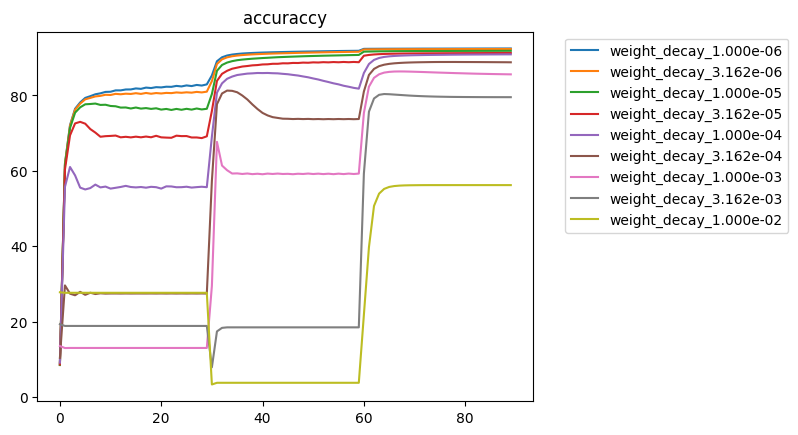

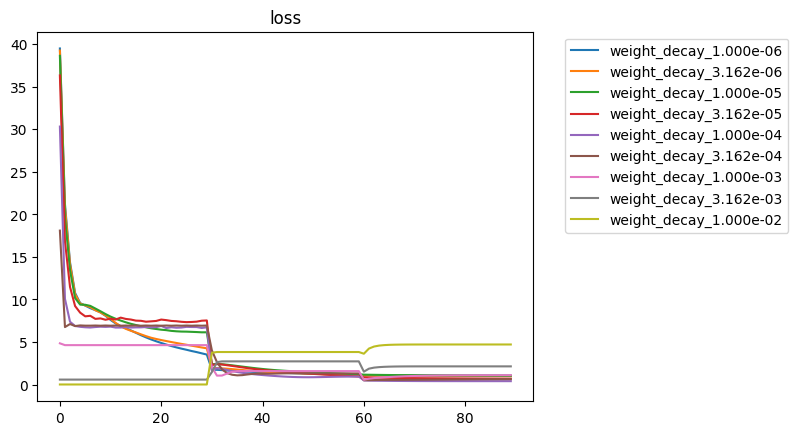

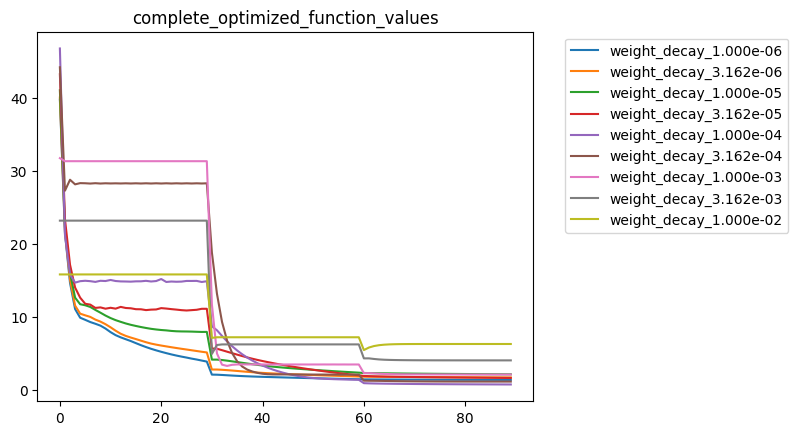

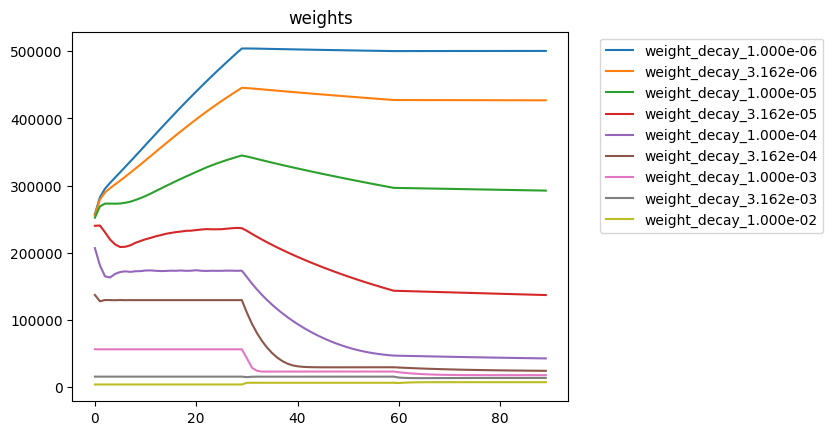

In [10]:
plot_data_per_wd(subdirectories, accuracy, "accuraccy")
plot_data_per_wd(subdirectories, loss, "loss")
plot_data_per_wd(subdirectories, complete_optimized_function_values, "complete_optimized_function_values")
plot_data_per_wd(subdirectories, weights, "weights")


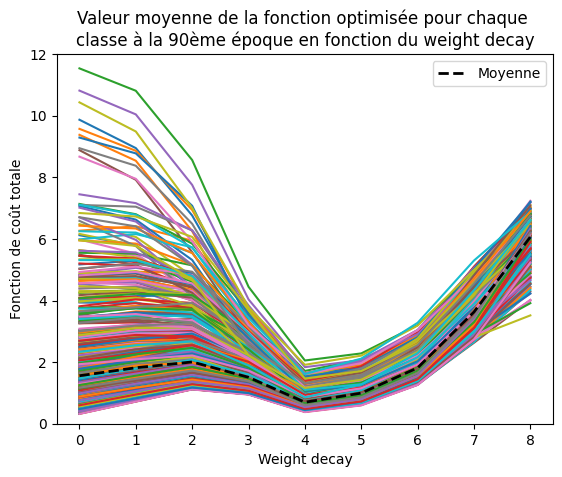

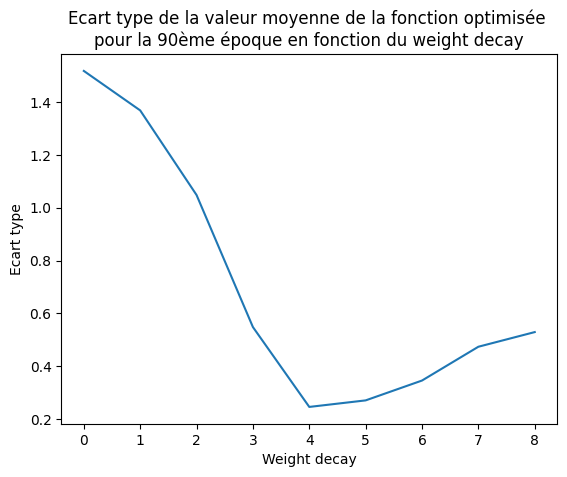

In [11]:
inte = torch.tensor([])
for i in mean_loss_class:
    inte = torch.cat((inte, i[89,:].unsqueeze(0)),dim=0)

plt.figure()
for i in range(1000):
    plt.plot(inte[:,i])
plt.plot(inte.mean(dim=1), color = 'black', linewidth ="2", linestyle="--", label = "Moyenne")
plt.title("Valeur moyenne de la fonction optimisée pour chaque \nclasse à la 90ème époque en fonction du weight decay")
plt.ylabel("Fonction de coût totale")
plt.xlabel("Weight decay")
plt.legend()
plt.ylim(0, 12)
plt.show()

plt.figure()
plt.title("Ecart type de la valeur moyenne de la fonction optimisée \npour la 90ème époque en fonction du weight decay")
plt.ylabel("Ecart type")
plt.xlabel("Weight decay")
plt.plot(inte.std(dim=1))
plt.show()

In [16]:
inte.mean(dim=0).shape

torch.Size([1000])

[ 72.   0.   0.   0. 928.   0.   0.   0.   0.]


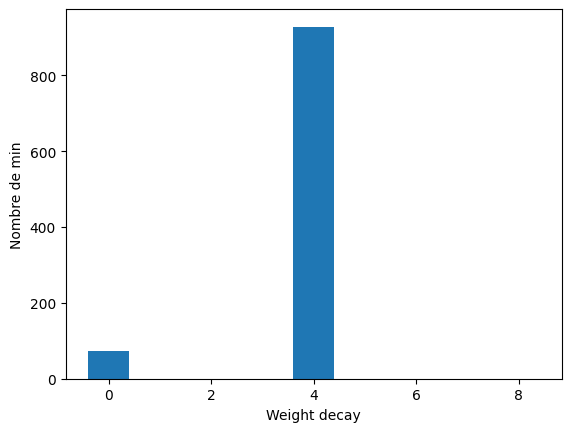

In [31]:
plt.figure()
y=np.zeros(9)
for i in range(1000):
    y[inte[:,i].argmin().item()] += 1
print(y)
plt.bar(np.arange(len(y)),y )
plt.xlabel("Weight decay")
plt.ylabel("Nombre de min")
plt.show()
